In [1]:
"""
Created on 30/12/2024

@author: federica montana

This file contains the main analysis of the indicators created in 2_indicators_creation.ipynb. In particular, it contains the following steps:
1. Load the indicators
2. Create the Helath Urban Design Index (HUDI) at city level
3. Create pivot df for domain and indicators
4. Plots: 
    - top and bottom cities for each indicator
    - indicators boxplots by clusters(with absolute and rescaled values)
    - correlation matrix
    - boxplots of domains by clusters
    - bar plot of the mean of the domains by clusters
    - Kendall correlation
    - HUDI top and bottom cities
    - HUDI distribution by clusters
    - Correlation betwrn HUDI and indicators
    - LISA cluster map
    - spider plot of the indicators for each city
5. Create the Helath Urban Design Index (HUDI) at grid level
6. Plots of the HUDI and domains at grid level and LISA plot

"""
# Import packages

import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import re

import seaborn as sns
import contextily as ctx
from matplotlib.lines import Line2D
from utility import clusters, domains, indicators, dom_ind_dict
from scipy.stats import kendalltau

import esda
from libpysal.weights import Queen
from splot.esda import lisa_cluster
from esda.moran import Moran


In [49]:
# Read all the indicators and save it in a new dataframe. Save two different DataFrames accordingly, depending on whether the scale is "grid" or "city."

scale = 'grid' # Set the scale if city or grid. 

# Create an empty dataframe
dfs = []
for cluster in clusters:
    # Iterate over domains and indicators
    for domain, indicators in dom_ind_dict.items():
        for indicator in indicators:
            # Skip Compactness if scale is grid
            if scale == "grid" and indicator == "Compactness":
                continue
            # Construct file path
            folder_path = f'DATA\\new_data\\{cluster}\\{scale}'
            filename = f'{domain}_{indicator}.csv'
            file_path = os.path.join(folder_path, filename)
            
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Add metadata columns
            df['domain'] = domain
            df['indicator'] = indicator
            
            # Append to the list of DataFrames
            dfs.append(df)
            
            # Concatenate DataFrames and remove duplicates
            if scale == 'grid':
                df_grid = pd.concat(dfs, ignore_index=True)
                df_grid = df_grid.drop_duplicates(subset=['gid', 'indicator', 'domain'])
            else:
                df_city = pd.concat(dfs, ignore_index=True)            


In [50]:
from utility import indicators, measures

# Create a dictionary indicator and associated unit measure 
indicator_to_measure = dict(zip(indicators, measures))

if scale == 'city':
    df = df_city.copy()
else:
    df = df_grid.copy()

# Add the 'measure' column to the DataFrame based on the 'indicator' column
df['measure'] = df['indicator'].map(indicator_to_measure)
df['country'] = df['urau_code'].str[:2]
df['urau_name_country'] = df['urau_name'] + ' (' + df['country'] + ')'

from utility import clusters
# Order by clusters
df['cluster'] = pd.Categorical(df['cluster'], categories=clusters, ordered=True)
# Sort the DataFrame by the 'cluster' column
top_bottom_cities = df.sort_values(by='cluster')

In [51]:
# Save df
if scale == 'city':
    df_city = df.copy()
    df_city.to_csv('results\\indicators\\data1.csv', index = False)
else:
    df_grid = df.copy()
    df_grid.to_csv('results\\indicators\\data2.csv', index = False)

Read


In [2]:
# Read directly the dataframes created above 

df_city = pd.read_csv('results\\indicators\\data1.csv')
df_grid = pd.read_csv('results\\indicators\\data2.csv')

Compute the HUDI and Rank - City level

In [23]:
### HUDI creation at city level 
## City level
df = df_city.copy()

# Do the mean of the rescaled indicators within the same domain
df['mean_domain'] = df.groupby(['urau_code', 'domain'])['rescaled_city'].transform('mean')
df = df.drop_duplicates(subset=['urau_code', 'domain'])

# Assign weights based on domain
df['weight'] = df['domain'].apply(lambda x: 0.5 if x == 'Sustainable Transportation' else 1)

# Calculate HUDI for each urau_code
def calculate_hudi(group):
    weighted_sum = (group['mean_domain'] * group['weight']).sum()
    total_weight = group['weight'].sum()
    return weighted_sum / total_weight

# Compute the HUDI for each urau_code 
hudi_results = df.groupby('urau_code').apply(calculate_hudi).reset_index(name='HUDI')
final_df = pd.merge(df, hudi_results, on='urau_code', how='left')
final_df.to_csv('results\\HUDI_domains.csv', index=False)

In [24]:
### HUDI creation at city level 
## City level
df = df_city.copy()

# Do the mean of the rescaled indicators within the same domain
df['mean_domain'] = df.groupby(['urau_code', 'domain'])['rescaled_city'].transform('mean')
df = df.drop_duplicates(subset=['urau_code', 'domain'])

# Assign weights based on domain
df['weight'] = df['domain'].apply(lambda x: 0.5 if x == 'Sustainable Transportation' else 1)

# Calculate HUDI for each urau_code
def calculate_hudi(group):
    weighted_sum = (group['mean_domain'] * group['weight']).sum()
    total_weight = group['weight'].sum()
    return weighted_sum / total_weight

# Compute the HUDI for each urau_code 
hudi_results = df.groupby('urau_code').apply(calculate_hudi).reset_index(name='HUDI')
final_df = pd.merge(df, hudi_results, on='urau_code', how='left')
final_df.to_csv('results\\HUDI_domains.csv', index=False)

#########################
#### Total Rank
final_df_rank = final_df.drop_duplicates(subset=['urau_code'])
final_df_rank = final_df_rank.copy()
final_df_rank['rank_tot'] = final_df_rank['HUDI'].rank(ascending=False, method='dense')

########################
#### Rank by clusters
final_df_rank = final_df_rank.copy()
final_df_rank['rank'] = final_df_rank.groupby('cluster')['HUDI'].rank(ascending=False, method='dense')
final_df_rank.to_csv('results\\df_rank0.csv', index = False)

# Round the HUDI, val_city, and rescaled_city columns to 2 decimal places
final_df_rank['HUDI'] = final_df_rank['HUDI'].round(2)
final_df_rank['val_city'] = final_df_rank['val_city'].round(2)
final_df_rank['rescaled_city'] = final_df_rank['rescaled_city'].round(2)


CREATE PIVOT DATAFRAME

In [25]:
# PIVOT - DOMAIN
data = final_df.copy() 

# Round the HUDI, val_city, rescaled_city columns and the mean domain to 2 decimal places
data['HUDI'] = data['HUDI'].round(2)
data['val_city'] = data['val_city'].round(2)
data['rescaled_city'] = data['rescaled_city'].round(2)
data['mean_domain'] = data['mean_domain'].round(2)

data['id'] = data.groupby('domain').cumcount()

# Pivot the DataFrame to wide format

pivot_df = data.pivot(index='urau_code', columns='domain', values='mean_domain').reset_index()

# Extract unique mapping of 'urau_code' and 'urau_name'
code_name_mapping = data[['urau_code', 'urau_name','cluster','HUDI']].drop_duplicates()

# Merge the pivoted DataFrame with the mapping
pivot_df = pivot_df.merge(code_name_mapping, on='urau_code', how='left')

# Reorder columns to place 'urau_name' next to 'urau_code'
columns = ['urau_code', 'urau_name','cluster','HUDI'] + [col for col in pivot_df.columns if col not in ['urau_code', 'urau_name','cluster','HUDI']]
pivot_df = pivot_df[columns]

# Display the result
pivot_df['country'] = pivot_df['urau_code'].str[:2]
# Save as desidered#pivot_df_resclaled = pivot_df.copy()
pivot_df_domain = pivot_df.copy()
pivot_df_domain.to_csv('RESULTS\\df_rank_domain.csv')
pivot_df

urau_code                                  urau_name             cluster  \
0     AT001C1                                       Wien  large metropolitan   
1     AT002C1                                       Graz              medium   
2     AT003C1                                       Linz               small   
3     AT004C1                                   Salzburg               small   
4     AT005C1                                  Innsbruck               small   
..        ...                                        ...                 ...   
912   UK582C1                                      Corby               small   
913   UK583C1                                  Kettering               small   
914   UK584C1                                 Inverclyde               small   
915   UK585C1                               Renfrewshire               small   
916   UK586C1  Derry__Strabane_Local_Government_District               small   

     HUDI  Environmental Quality  Green Spaces Accessibility  \
0    5.29                   4.33                        5.53   
1    5.30                   4.20                        5.78   
2    5.47                   5.19                        5.39   
3    6.03                   5.80                        6.95   
4    5.43                   3.84                        6.50   
..    ...                    ...                         ...   
912  5.72                   6.94                        5.92   
913  5.44                   6.83                        5.15   
914  4.78                   7.40                        4.10   
915  5.55                   7.32                        5.23   
916  4.82                   7.15                        3.41   

     Sustainable Transportation  Urban Design country  
0                          5.39          5.97      AT  
1                          5.25          5.94      AT  
2                          5.09          6.03      AT  
3                          4.67          6.04      AT  
4                          5.04          6.16      AT  
..                          ...           ...     ...  
912                        2.58          5.87      UK  
913                        3.57          5.26      UK  
914                        3.17          3.64      UK  
915                        3.36          5.18      UK  
916                        3.24          4.68      UK  

[917 rows x 9 columns]

In [26]:
# PIVOT - INDICATOR
data = df_city.copy()
final_df_rank = final_df_rank.copy() 

data['id'] = data.groupby('indicator').cumcount()

# Pivot the DataFrame to wide format
col = 'rescaled_city'
pivot_df = data.pivot(index='urau_code', columns='indicator', values=col).reset_index()

# Add the 'urau_name' column
# Extract unique mapping of 'urau_code' and 'urau_name'
code_name_mapping = data[['urau_code', 'urau_name','cluster','measure']].drop_duplicates()

# Merge the pivoted DataFrame with the mapping
pivot_df = pivot_df.merge(code_name_mapping, on='urau_code', how='left')

# Reorder columns to place 'urau_name' next to 'urau_code'
columns = ['urau_code', 'urau_name','cluster','measure'] + [col for col in pivot_df.columns if col not in ['urau_code', 'urau_name','cluster','measure']]
pivot_df = pivot_df[columns]
pivot_df['country'] = pivot_df['urau_code'].str[:2]

df = pd.merge(pivot_df,final_df_rank[['urau_code','HUDI','rank','rank_tot']],on='urau_code',how='right')
df = df.drop_duplicates(subset=['urau_code'])

# Sort by 'cluster' and then by 'rank' within each cluster
pivot_df_indicator = df.sort_values(by=['cluster', 'rank'])

# Reset index for a clean output if needed
pivot_df_indicator.reset_index(drop=True, inplace=True)
pivot_df_indicator = pivot_df_indicator.round(2)
pivot_df_indicator.to_csv(f'results\\df_rank_{col}.csv', index = False)
pivot_df_indicator.to_excel(f'results\\df_rank_{col}.xlsx', index = False)
pivot_df_indicator

urau_code  urau_name             cluster       measure  \
0     ES001C1     Madrid  large metropolitan  dwellings/ha   
1     ES002C1  Barcelona  large metropolitan  dwellings/ha   
2     AT001C1       Wien  large metropolitan  dwellings/ha   
3     UK001K2     London  large metropolitan  dwellings/ha   
4     IT001C1       Roma  large metropolitan  dwellings/ha   
..        ...        ...                 ...           ...   
912   PL513C1  Wloclawek         small towns  dwellings/ha   
913   IE005C1  Waterford         small towns  dwellings/ha   
914   IT070C1    Saronno         small towns  dwellings/ha   
915   BG018C1     Vratsa         small towns  dwellings/ha   
916   IT060C1      Lecco         small towns  dwellings/ha   

     Access to large green spaces  Air quality (NO2)  Air quality (PM2.5)  \
0                            6.72               0.29                 5.64   
1                            5.81               0.81                 3.28   
2                            5.68               4.15                 4.73   
3                            7.27               4.02                 7.11   
4                            7.87               4.47                 3.79   
..                            ...                ...                  ...   
912                          4.34               6.89                 4.72   
913                          3.57               9.29                 8.82   
914                          3.99               0.95                 0.00   
915                          3.23               8.12                 6.41   
916                          7.37               2.05                 2.86   

     Compactness  Lower urban heat islands  Mid-rise development  ...  \
0            9.7                     10.00                  7.91  ...   
1           10.0                      5.34                 10.00  ...   
2            9.7                      4.58                  7.76  ...   
3            9.8                      3.96                  7.78  ...   
4            8.1                      3.82                  7.39  ...   
..           ...                       ...                   ...  ...   
912          0.0                      8.01                  4.15  ...   
913          0.0                      8.56                  0.63  ...   
914          0.0                      8.79                  9.95  ...   
915          0.0                      7.99                  5.85  ...   
916          0.0                      0.00                  6.73  ...   

     Opportunity to walk  Optimal dwelling density  Permeability  \
0                   7.17                     10.00          1.80   
1                   9.55                     10.00          1.41   
2                   7.70                      4.42          1.99   
3                   5.86                      3.32          1.80   
4                   4.89                      1.82          2.82   
..                   ...                       ...           ...   
912                 7.43                      0.25          2.76   
913                 3.27                      3.84          3.17   
914                 3.38                      5.51          1.86   
915                 3.66                      4.60          1.89   
916                 5.55                      5.20          2.17   

     Public transport stops  Surrounding greenness  \
0                      5.92                   3.99   
1                      7.87                   1.54   
2                      4.58                   3.86   
3                      4.74                   2.33   
4                      4.22                   3.15   
..                      ...                    ...   
912                    3.79                   3.61   
913                    1.43                   4.51   
914                    3.99                   2.85   
915                    1.34                   2.95   
916                    2.13                   

In [27]:
## Create a unique dataframe with both the rescaled values and absolute values
# Load the data
df1 = pd.read_csv('results\\df_rank_rescaled_city.csv')
df2 = pd.read_csv('results\\df_rank_val_city.csv')

df_merged = pd.merge(
    df1,
    df2,
    on='urau_code',             
    how='left',                 
    suffixes=('_rescaled', '_val')
)

# Rename columns to remove '_rescaled' suffix
df_merged.rename(columns={
    'urau_name_rescaled': 'urau_name',
    'cluster_rescaled': 'cluster',
    'measure_rescaled': 'measure',
    'country_rescaled': 'country',
    'HUDI_rescaled': 'HUDI',
    'rank_rescaled': 'rank',
    'rank_tot_rescaled': 'rank_tot'
}, inplace=True)

# Drop the specified columns
df_merged.drop(columns=[
    'urau_name_val', 'cluster_val', 'measure_val', 'country_val', 'HUDI_val',
    'rank_val', 'rank_tot_val'
], inplace=True)

# Preview the updated DataFrame
df_merged.to_excel('results\\df_website.xlsx')

In [28]:
# Include geometry
b = gpd.read_file('DATA\\data\\all_cities.shp') 
b = b.to_crs('EPSG:3035')
b['centroid'] = b.geometry.centroid

In [29]:
## Merge the pivot_df_indicator with the geometry of the city to create the plots in the geo_plots.ipynb  
# Make a copy of the pivot_df_indicator DataFrame
pivot_df_indicator = pivot_df_indicator.copy()

# Merge the pivot_df_indicator DataFrame with the 'centroid' column from the GeoDataFrame 'b'
gdf_pivot = pd.merge(pivot_df_indicator, b[['urau_code', 'centroid']], on='urau_code', how='inner')

# Convert the merged DataFrame to a GeoDataFrame using the 'centroid' column as geometry
gdf_pivot2 = gpd.GeoDataFrame(gdf_pivot, geometry=gdf_pivot['centroid'])

# Create another GeoDataFrame for plotting in QGIS, setting 'centroid' as the active geometry
gdf_plot_qgis = gpd.GeoDataFrame(gdf_pivot2, geometry=gdf_pivot2['centroid'], crs=gdf_pivot2.crs)

# Set 'centroid' as the active geometry and drop any existing 'geometry' column
gdf_plot_qgis = gdf_plot_qgis.set_geometry('centroid').drop(columns=['geometry'], errors='ignore')

# Convert categorical columns to string type
for column in gdf_plot_qgis.select_dtypes(include='category').columns:
    gdf_plot_qgis[column] = gdf_plot_qgis[column].astype(str)

# Save the GeoDataFrame to a shapefile
gdf_plot_qgis.to_file('results\\gdf_plot_qgis.shp', driver="ESRI Shapefile")

C:\Users\fmontana\AppData\Local\Temp\ipykernel_7908\1095349873.py:22: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_plot_qgis.to_file('results\\gdf_plot_qgis.shp', driver="ESRI Shapefile")
C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Access to large green spaces' to 'Access to'
  ogr_write(
C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Air quality (NO2)' to 'Air qualit'
  ogr_write(
C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Air quality (PM2.5)' to 'Air qual_1'
  ogr_write(
C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Compactness' to 'Compactnes'
  ogr_write(
C:\Users\fmontana

## PLOTS

TOP AND BOTTOM CITIES FOR EACH INDICATOR

In [30]:
from utility import clusters
# Order by clusters
df_city['cluster'] = pd.Categorical(df_city['cluster'], categories=clusters, ordered=True)

In [31]:
# This plot visualizes the top and bottom 5 cities for each indicator across different clusters.
# The cities are grouped by clusters and ranked based on their values for each indicator.
# The bars are colored according to their cluster and whether they are in the top 5 or bottom 5.
# Legends are added for specific indicators to help identify the clusters and their rankings.

df = df_city.copy()
col = 'val_city'
cluster_palette = {
    'large metropolitan': ('#1f77b4', '#aec7e8'),  # Blue shades
    'metropolitan': ('#ff7f0e', '#ffbb78'),  # Orange shades
    'medium': ('#2ca02c', '#98df8a'),  # Green shades
    'small': ('#d62728', '#ff9896'),  # Red shades
    'small towns': ('#9467bd', '#c5b0d5')  # Purple shades
}

# Function to get Top and Bottom 5 cities per indicator and cluster
def get_top_bottom_cities(df, cluster_col, indicator_col, value_col):
    top_bottom_df = (
        df.groupby([cluster_col, indicator_col])
        .apply(lambda x: pd.concat([
            x.nlargest(5, value_col),  # Top 5 cities
            x.nsmallest(5, value_col)  # Bottom 5 cities
        ]))
        .reset_index(drop=True)
    )
    return top_bottom_df

# Extract Top and Bottom 5 cities based on 'col'
top_bottom_cities = get_top_bottom_cities(df, 'cluster', 'indicator', col)

# Define the indicators where the legend should be shown
indicators_with_legend = [
    "Optimal dwelling density", 
    "Universal access to green spaces", 
    "Air quality (PM2.5)",
    'Opportunity to walk'
]

# Loop through each indicator to create and save individual plots
unique_indicators = top_bottom_cities['indicator'].unique()

for i, indicator in enumerate(unique_indicators):
    indicator_data = top_bottom_cities[top_bottom_cities['indicator'] == indicator].copy()
    
    # Identify Top 5 and Bottom 5 cities
    indicator_data['Rank'] = indicator_data.groupby('cluster')[col].rank(method='first', ascending=False)
    indicator_data['Top_Bottom'] = indicator_data['Rank'].apply(lambda x: 'Top 5' if x <= 5 else 'Bottom 5')
    
    # Apply color based on Top/Bottom and cluster
    indicator_data['Color'] = indicator_data.apply(
        lambda row: cluster_palette[row['cluster']][0] if row['Top_Bottom'] == 'Top 5' 
        else cluster_palette[row['cluster']][1], axis=1
    )
    
    # Plot the data
    plt.figure(figsize=(16, 8))
    bars = plt.bar(
        x=indicator_data['urau_name_country'],
        height=indicator_data[col],
        color=indicator_data['Color'],
        edgecolor='black'
    )
    
    plt.title(f"Top and Bottom 5 Cities for Indicator: '{indicator}' Across Clusters")
    plt.xlabel('City')
    plt.ylabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    
    # Add Legend only for specific conditions
    if i == 0 or indicator in indicators_with_legend:
        legend_elements = [
            Line2D([0], [0], color=cluster_palette[cluster][0], lw=4, label=f'{cluster} (Top 5)')
            for cluster in cluster_palette.keys()
        ] + [
            Line2D([0], [0], color=cluster_palette[cluster][1], lw=4, label=f'{cluster} (Bottom 5)')
            for cluster in cluster_palette.keys()
        ]
        plt.legend(handles=legend_elements, title='Cluster & Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join('plots', 'indicators', 'top_bottom', col ,f"{indicator.replace(' ', '_')}.png")
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)  # Ensure directories exist

    plt.savefig(plot_path, dpi=300, bbox_inches='tight')    
    plt.close()

INDICATORS BOX PLOTS - ABSOLUTE VALUES

In [32]:
####INDICATORS BOX PLOTS - ABSOLUTE VALUES

# This plot visualizes the distribution of absolute values for each indicator across different clusters.
# Each subplot represents a different indicator, and within each subplot, the data is grouped by clusters.
# The boxplots show the spread of values for each indicator within each cluster, with the median indicated by a red line.
# The boxes are colored light blue, and the grid lines are added for better readability.

df = df_city.copy()

# Calculate number of rows and columns needed
n_indicators = len(indicators)
n_rows = int(np.ceil(np.sqrt(n_indicators)))  # Square root rounded up
n_cols = int(np.ceil(n_indicators / n_rows))  # Adjust columns to fit all indicators

# Create figure with appropriate subplot layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.ravel() if n_indicators > 1 else [axes]  # Handle single indicator case

# For each indicator, create boxplot by cluster and run statistical test
for idx, indicator in enumerate(indicators):
    data_by_cluster = []
    cluster_names = []
    
    for cluster in df['cluster'].unique():
        data = df[(df['indicator'] == indicator) & 
                          (df['cluster'] == cluster)]['val_city']
        data_by_cluster.append(data)
        cluster_names.append(cluster)
    
    # Create boxplot
    axes[idx].boxplot(data_by_cluster, 
                     patch_artist=True,
                     boxprops=dict(facecolor="lightblue", color="blue"),
                     medianprops=dict(color="red"))
    
    axes[idx].set_xticklabels(cluster_names, rotation=45, ha='right')
    axes[idx].set_title(indicator, pad=20)
    axes[idx].grid(alpha=0.3)

# Hide empty subplots if any
for idx in range(len(indicators), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f"Absolute values indicators by cluster", y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig(f'plots\\indicators\\indicators box abs values.png', dpi=300, bbox_inches='tight')
plt.close()


INDICATORS BOX PLOTS - RESCALED VALUES

In [33]:
####INDICATORS BOX PLOTS - RESCALED VALUES

# This plot visualizes the distribution of rescaled values for each indicator across different clusters.
# Each subplot represents a different indicator, and within each subplot, the data is grouped by clusters.
# The boxplots show the spread of values for each indicator within each cluster, with the median indicated by a red line.
# The boxes are colored light blue, and the grid lines are added for better readability.

# Calculate number of rows and columns needed
df = df_city.copy()
n_indicators = len(indicators)
n_rows = int(np.ceil(np.sqrt(n_indicators)))  # Square root rounded up
n_cols = int(np.ceil(n_indicators / n_rows))  # Adjust columns to fit all indicators

# Create figure with appropriate subplot layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.ravel() if n_indicators > 1 else [axes]  # Handle single indicator case

# For each indicator, create boxplot by cluster and run statistical test
for idx, indicator in enumerate(indicators):
    data_by_cluster = []
    cluster_names = []
    
    for cluster in df['cluster'].unique():
        data = df[(df['indicator'] == indicator) & 
                          (df['cluster'] == cluster)]['rescaled_city']
        data_by_cluster.append(data)
        cluster_names.append(cluster)
    
    # Create boxplot
    axes[idx].boxplot(data_by_cluster, 
                     patch_artist=True,
                     boxprops=dict(facecolor="lightblue", color="blue"),
                     medianprops=dict(color="red"))
    
    axes[idx].set_xticklabels(cluster_names, rotation=45, ha='right')
    axes[idx].set_title(indicator, pad=20)
    axes[idx].grid(alpha=0.3)

# Hide empty subplots if any
for idx in range(len(indicators), len(axes)):
    axes[idx].set_visible(False)
    # Set y-axis scale for all subplots
    y_min, y_max = axes[0].get_ylim()
    for ax in axes:
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Rescaled Indicators by Cluster", y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig(f'plots\\indicators\\indicators box rescaled values.png', dpi=300, bbox_inches='tight')
plt.close()


CORRELATION MATRIX - RESCALED VALUES

In [34]:
##### CORRELATION MATRIX - RESCALED VALUES

#  Correlation matrix of the indicators
#This plot visualizes the correlation matrix of the rescaled values for each indicator across different cities. The correlation matrix helps to understand the relationships between different indicators by showing how changes in one indicator are associated with changes in another. The values range from -1 to 1, where:
# - 1 indicates a perfect positive correlation,
# - -1 indicates a perfect negative correlation,
# - 0 indicates no correlation.

#The heatmap uses a color gradient from cool (blue) to warm (red) to represent the correlation coefficients, with annotations displaying the exact values. This visualization helps to identify which indicators are strongly correlated, either positively or negatively, and which are independent of each other.

df = df_city.copy() #grid
col = 'rescaled_city'
# Step 1: Handle duplicates by aggregating 'rescaled_col'
df_cleaned = (
    df.groupby(['urau_code', 'indicator'], as_index=False)
    .agg({col: 'mean'})  # Aggregate duplicates with the mean
)

# Step 2: Pivot data to get indicators as columns
pivot_data = df_cleaned.pivot(
    index='urau_code',
    columns='indicator',
    values=col
).reset_index()

# Step 3: Calculate the correlation matrix
corr_matrix = pivot_data.drop('urau_code', axis=1).corr()
plt.figure(figsize=(12, 10)) 
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title("Correlation Matrix for Indicators Values")
plt.savefig(f'plots\\indicators\\corr_{col}.png', dpi=300, bbox_inches='tight')  # Save with high resolution

plt.close()

BOX PLOTS FOR DOMAINS 

In [35]:
#### MEAN DOMAINS BY CLUSTER 

# This plot visualizes the distribution of rescaled values for each domain across different clusters.
# Each subplot represents a different domain, and within each subplot, the data is grouped by clusters.
# The boxplots show the spread of values for each domain within each cluster, with the median indicated by a red line.
# The boxes are colored light blue, and the grid lines are added for better readability.

# Calculate number of rows and columns needed
df = df_city.copy()
n_indicators = len(domains)
n_rows = int(np.ceil(np.sqrt(n_indicators)))  # Square root rounded up
n_cols = int(np.ceil(n_indicators / n_rows))  # Adjust columns to fit all indicators

# Create figure with appropriate subplot layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.ravel() if n_indicators > 1 else [axes]  # Handle single indicator case

# For each indicator, create boxplot by cluster and run statistical test
for idx, indicator in enumerate(domains):
    data_by_cluster = []
    cluster_names = []
    
    for cluster in df['cluster'].unique():
        data = df[(df['domain'] == indicator) & 
                          (df['cluster'] == cluster)]['rescaled_city']
        data_by_cluster.append(data)
        cluster_names.append(cluster)
    
    # Create boxplot
    axes[idx].boxplot(data_by_cluster, 
                     patch_artist=True,
                     boxprops=dict(facecolor="lightblue", color="blue"),
                     medianprops=dict(color="red"))
    
    axes[idx].set_xticklabels(cluster_names, rotation=45, ha='right')
    axes[idx].set_title(indicator, pad=20)
    axes[idx].grid(alpha=0.3)

# Hide empty subplots if any
for idx in range(len(domains), len(axes)):
    axes[idx].set_visible(False)
    # Set y-axis scale for all subplots
    y_min, y_max = axes[0].get_ylim()
    for ax in axes:
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Mean domain by cluster", y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig(f'PLOTS\\domains\\domains rescaled value by cluster.png', dpi=300, bbox_inches='tight')
plt.close()


FIG MEAN OF THE DOMAINS FOR EACH CLUSTER

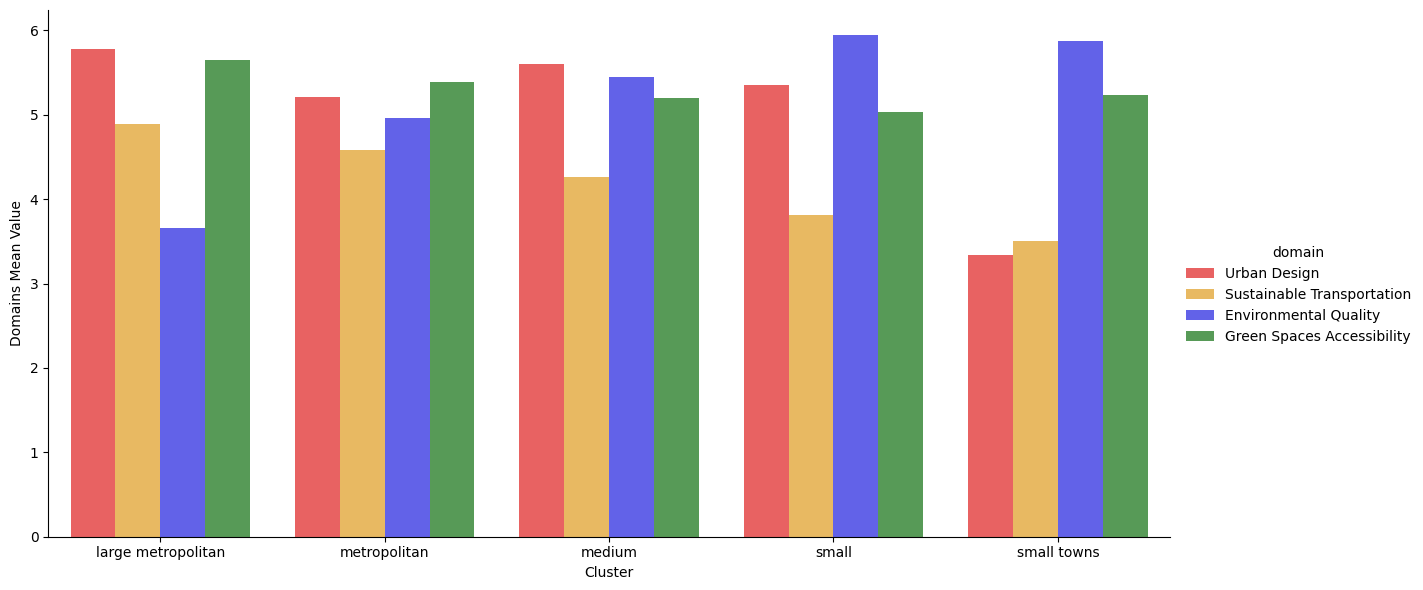

In [36]:
# This plot visualizes the mean value of each domain within different clusters.
# The data is grouped by domain and cluster, and the mean values are calculated.
# The bar plot shows the mean values for each domain within each cluster, with different colors representing different domains.

df = df_city.copy()
df['cluster'] = pd.Categorical(df['cluster'], categories=clusters, ordered=True)
df = df.sort_values(by='cluster')

# Compute statistics
stat_domain = df.groupby(['domain','cluster'])['rescaled_city'].describe().round(2)
from utility import domains
stat_domain = stat_domain.loc[domains]

# Compute the mean of the indicators inside the same domain
df['mean_domain'] = df.groupby(['urau_code', 'domain'])['rescaled_city'].transform('mean')
df = df.drop_duplicates(subset=['urau_code', 'domain'])

# Compute the mean of the domain in the same cluster
df2 = df.copy()
df2['mean_value_domain_cluster'] = df2.groupby(['cluster', 'domain'])['mean_domain'].transform('mean')
df2 = df2.drop_duplicates(subset=['cluster','domain'])

# Order by cluster
df2['cluster'] = pd.Categorical(df2['cluster'], categories=clusters, ordered=True)
df2 = df2.sort_values(by='cluster')

# Order by domain
df2['domain'] = pd.Categorical(df2['domain'], categories=domains, ordered=True)
df2 = df2.sort_values(by='domain')

# Plot
colors = ['r', 'orange','b', 'g']
ax = sns.catplot(data=df2, kind="bar", x="cluster", y=df2['mean_value_domain_cluster'],
                 hue="domain", alpha=0.7,
                 height=6, aspect=2, palette=colors)
# Add title and labels
plt.xlabel("Cluster")
plt.ylabel("Domains Mean Value")

plt.savefig('PLOTS/domains\\cluster_domain_mean.png', bbox_inches='tight', pad_inches=0)


In [37]:
stat_domain

count  mean   std   min   25%  \
domain                     cluster                                              
Urban Design               large metropolitan    44.0  5.78  3.68  0.00  1.89   
                           metropolitan         212.0  5.21  2.94  0.00  2.56   
                           medium               708.0  5.60  2.75  0.00  3.10   
                           small               2552.0  5.35  2.87  0.00  3.09   
                           small towns          152.0  3.34  2.93  0.00  0.00   
Sustainable Transportation large metropolitan    33.0  4.89  2.30  0.98  3.36   
                           metropolitan         159.0  4.59  2.14  0.53  2.93   
                           medium               531.0  4.26  1.98  0.00  2.70   
                           small               1914.0  3.81  2.06  0.00  2.29   
                           small towns          114.0  3.50  2.31  0.00  1.91   
Environmental Quality      large metropolitan    44.0  3.65  1.97  0.00  2.76   
                           metropolitan         212.0  4.97  1.92  0.00  3.56   
                           medium               708.0  5.45  1.74  0.00  4.23   
                           small               2552.0  5.94  1.70  0.00  4.76   
                           small towns          152.0  5.87  2.32  0.00  4.43   
Green Spaces Accessibility large metropolitan    22.0  5.64  1.11  2.95  5.03   
                           metropolitan         106.0  5.39  1.14  2.54  4.56   
                           medium               354.0  5.20  1.27  1.24  4.44   
                           small               1276.0  5.04  1.55  0.00  4.12   
                           small towns           76.0  5.23  1.58  2.39  3.91   

                                                50%   75%    max  
domain                     cluster                                
Urban Design               large metropolitan  7.26  9.56  10.00  
                           metropolitan        4.66  8.06  10.00  
                           medium              5.21  8.30  10.00  
                           small               4.70  8.21  10.00  
                           small towns         3.20  5.42  10.00  
Sustainable Transportation large metropolitan  4.41  6.90   9.55  
                           metropolitan        4.21  6.28   9.61  
                           medium              3.99  5.53   9.60  
                           small               3.57  5.21   9.93  
                           small towns         3.30  4.84   9.02  
Environmental Quality      large metropolitan  3.84  4.63  10.00  
                           metropolitan        5.28  6.29  10.00  
                           medium              5.72  6.53  10.00  
                           small               6.38  7.18  10.00  
                           small towns         6.35  7.73  10.00  
Green Spaces Accessibility large metropolitan  5.64  6.23   7.87  
                           metropolitan        5.27  6.24   8.46  
                           medium              5.29  6.05   8.31  
                           small               5.16  6.11   9.39  
                           small towns         5.25  6.33   8.86

KENDALL CORRELATION 

In [ ]:
### Compare the ranking with the ranking with equal weight

## Step 1: Compute equal weight ranking (rank_w1)
# Compute the mean of the rescaled indicators within the same domain
df = df_city.copy()
df['mean_domain'] = df.groupby(['urau_code', 'domain'])['rescaled_city'].transform('mean')
df = df.drop_duplicates(subset=['urau_code', 'domain'])

## Step 2: Compute the HUDI score for each city
# Compute the mean of 'mean_domain' for each urau_code
final_df2 = df.copy()
final_df2['HUDI'] = final_df2.groupby('urau_code')['mean_domain'].transform('mean')
final_df2['HUDI'] = final_df2['HUDI'].round(2)

## Step 3: Compute the total rank based on HUDI
df3 = final_df2.drop_duplicates(subset=['urau_code'])
df3 = df3.copy()
df3['rank_tot'] = df3['HUDI'].rank(ascending=False, method='first')

## Step 4: Compute the rank by clusters based on HUDI
df3 = df3.copy()
df3['rank_w1'] = df3.groupby('cluster')['HUDI'].rank(ascending=False, method='dense')
df3 = df3.copy()
df3.to_csv('results\\df_rank0_2.csv', index=False)

## Step 5: Merge weighted ranking (rank) with un-weighted ranking (rank_w1)
merged_df = pd.merge(final_df_rank[['urau_code', 'rank', 'cluster']], df3[['urau_code', 'rank_w1']], on='urau_code')

## Step 6: Calculate Kendall's Tau correlation between the two rankings
tau, p_value = kendalltau(merged_df['rank'], merged_df['rank_w1'])

## Step 7: Print the results
print(f"Kendall's Tau: {tau}")
print(f"P-value: {p_value}")

Kendall's Tau: 0.8788018956686832
P-value: 0.0


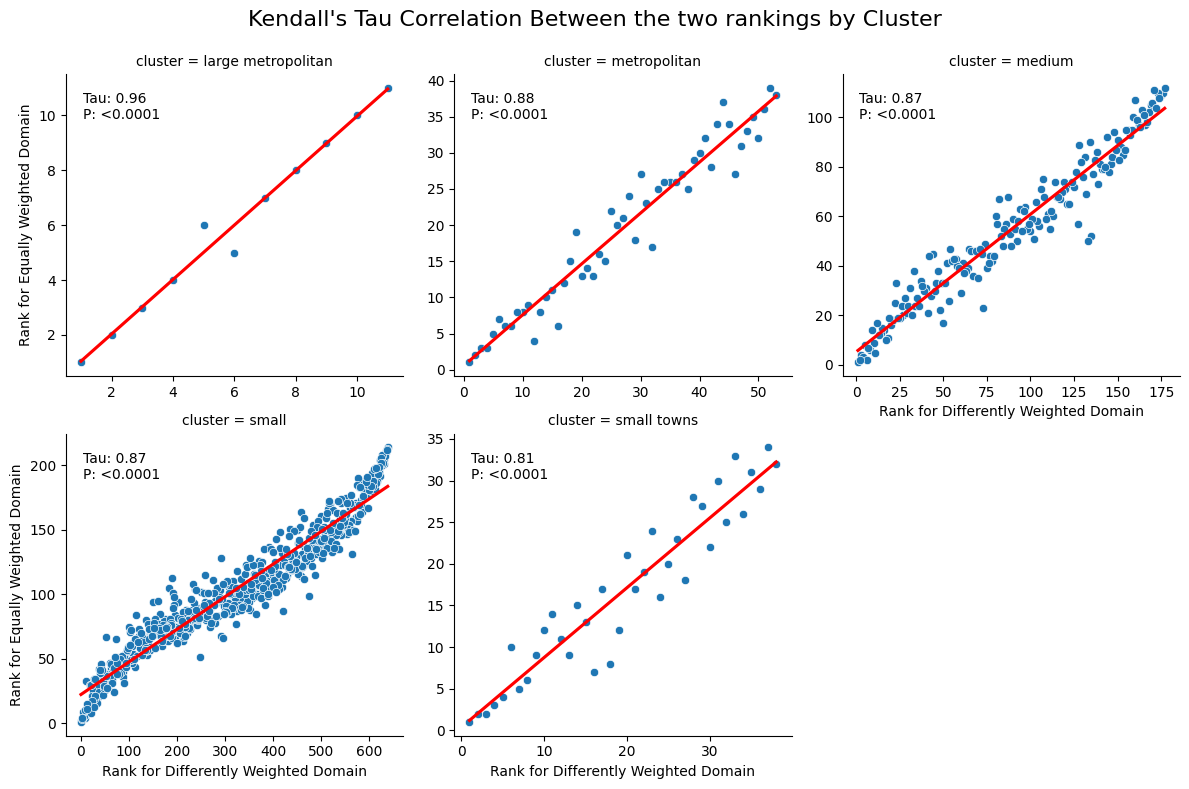

In [40]:
# Plot scatter plot divided by cluster with regression line and Kendall's Tau annotation
g = sns.FacetGrid(merged_df, col='cluster', col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x='rank', y='rank_w1')
g.map_dataframe(sns.regplot, x='rank', y='rank_w1', scatter=False, color='r', ci=None)

# Add Kendall's Tau annotation to each subplot
for ax, (cluster, sub_df) in zip(g.axes.flat, merged_df.groupby('cluster')):
    tau, p_value = kendalltau(sub_df['rank'], sub_df['rank_w1'])
    ax.annotate(f'Tau: {tau:.2f}\nP: <0.0001',
                xy=(0.05, 0.85), xycoords='axes fraction',
                fontsize=10, color='black')
    
g.set_axis_labels("Rank for Differently Weighted Domain", "Rank for Equally Weighted Domain")

# Global title and layout adjustments
g.fig.suptitle("Kendall's Tau Correlation Between the two rankings by Cluster", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)
plt.savefig('PLOTS\\ranks_coll.png', dpi=300, bbox_inches='tight')
plt.show()


In [41]:
df = pivot_df_domain.copy()
df[df['cluster'] == 'large metropolitan'].sort_values(by='HUDI', ascending=False).set_index('urau_name')[['Urban Design', 'Sustainable Transportation', 'Environmental Quality', 'Green Spaces Accessibility']]


Urban Design  Sustainable Transportation  Environmental Quality  \
urau_name                                                                    
Madrid             7.35                        5.28                   4.98   
Barcelona          7.85                        7.14                   2.74   
Wien               5.97                        5.39                   4.33   
London             5.68                        4.56                   4.36   
Roma               5.03                        3.72                   3.81   
Paris              7.47                        6.31                   1.68   
Budapest           5.38                        4.28                   3.82   
Berlin             5.34                        4.46                   3.50   
Bucuresti          6.52                        3.14                   3.42   
Warszawa           4.22                        5.44                   2.62   
Hamburg            2.80                        4.13                   4.92   

           Green Spaces Accessibility  
urau_name                              
Madrid                           6.16  
Barcelona                        5.70  
Wien                             5.53  
London                           6.16  
Roma                             7.06  
Paris                            5.21  
Budapest                         5.77  
Berlin                           5.47  
Bucuresti                        4.87  
Warszawa                         5.55  
Hamburg                          4.60

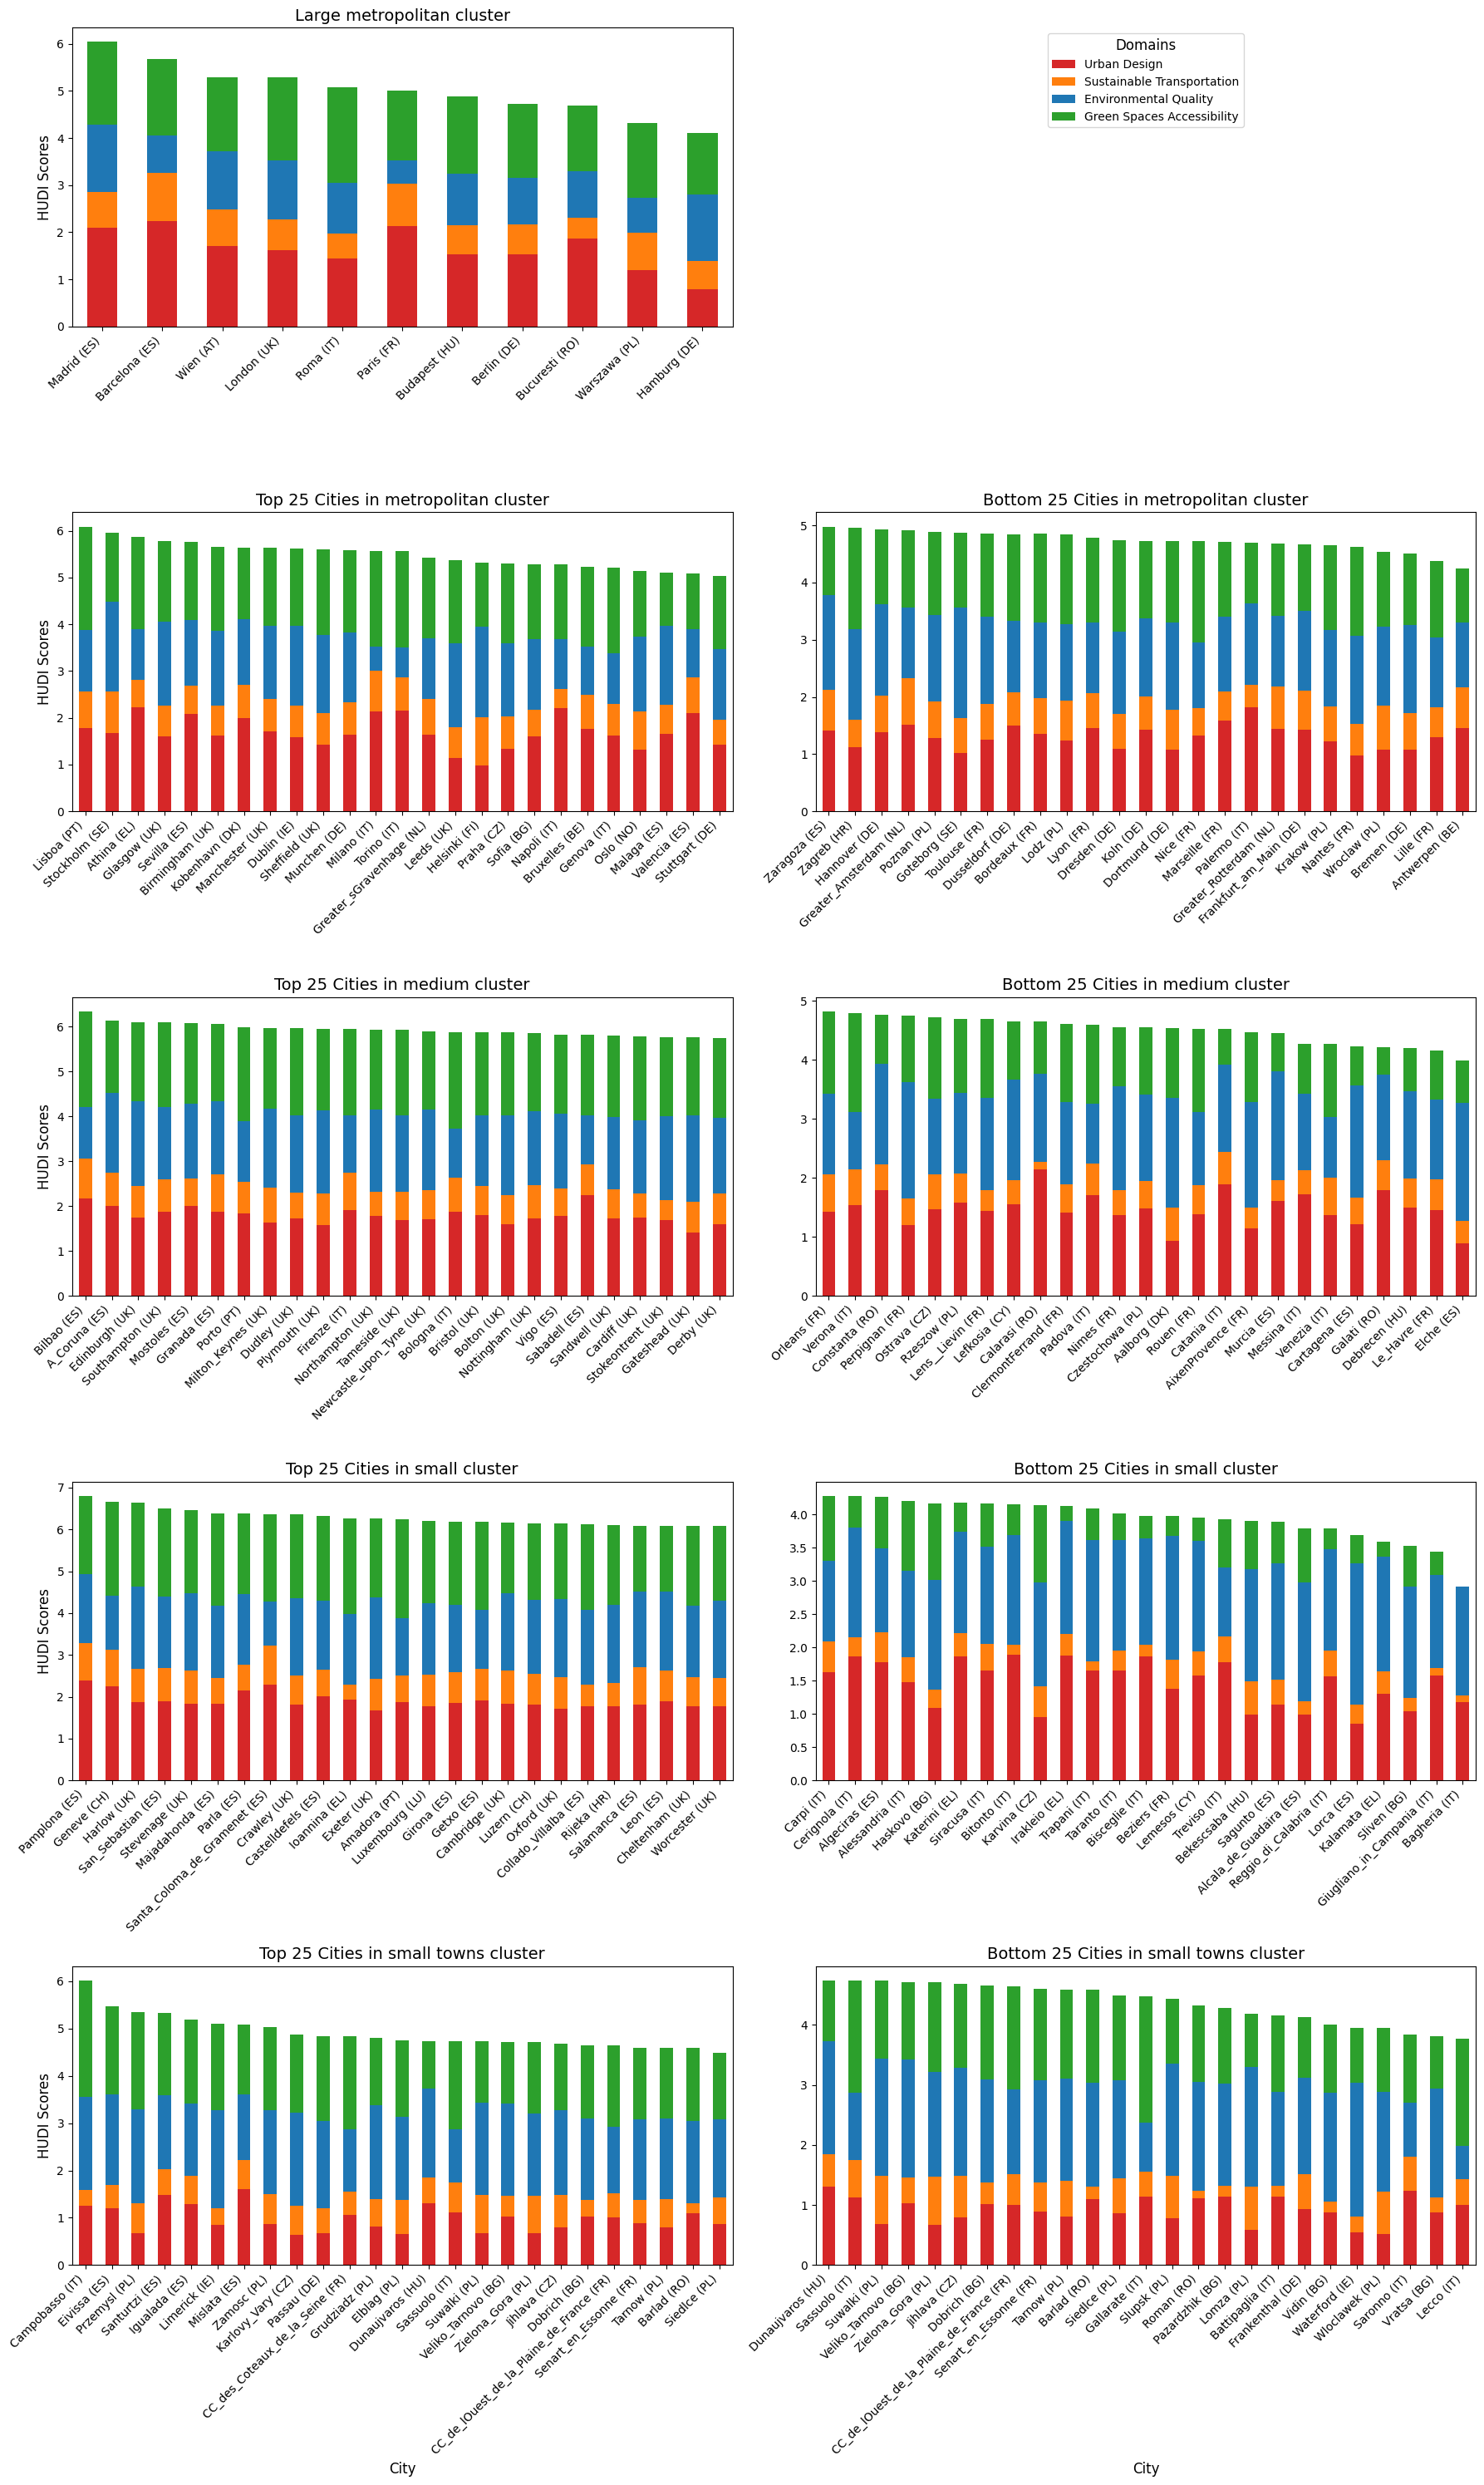

In [42]:
# Plotting Top and Bottom Cities for Each Cluster - 25 cities
# Colors for each domain

from utility import clusters

# Create a copy of the pivot_df_domain DataFrame
df = pivot_df_domain.copy()
df['urau_name_country'] = df['urau_name'] + ' (' + df['country'] + ')'

# Compute the top 25 cities per cluster based on HUDI (Descending within each cluster)
top_cities_per_cluster = (
    df.groupby('cluster')
    .apply(lambda x: x.nlargest(25, 'HUDI'))
    .reset_index(drop=True)
    .sort_values(by=['cluster', 'HUDI'], ascending=[True, False])
)

# Compute the bottom 25 cities per cluster based on HUDI (Ascending within each cluster)
bottom_cities_per_cluster = (
    df.groupby('cluster')
    .apply(lambda x: x.nsmallest(25, 'HUDI'))
    .reset_index(drop=True)
    .sort_values(by=['cluster', 'HUDI'], ascending=[True, False])
)

# Custom Colors
custom_colors = {
    'Urban Design': '#d62728',
    'Sustainable Transportation': '#ff7f0e',
    'Environmental Quality': '#1f77b4',
    'Green Spaces Accessibility': '#2ca02c'
}

# Plotting Top and Bottom Cities for Each Cluster
fig, axes = plt.subplots(nrows=len(clusters), ncols=2, figsize=(18, 6 * len(clusters)))

for i, cluster in enumerate(clusters):
    if cluster == 'large metropolitan':
        cluster_data = (
            df[df['cluster'] == 'large metropolitan']
            .sort_values(by='HUDI', ascending=False)
            .set_index('urau_name_country')[['Urban Design', 'Sustainable Transportation', 'Environmental Quality', 'Green Spaces Accessibility']]
        )
        cluster_data['Urban Design'] *= 1 / 3.5
        cluster_data['Environmental Quality'] *= 1 / 3.5
        cluster_data['Green Spaces Accessibility'] *= 1 / 3.5
        cluster_data['Sustainable Transportation'] *= 0.5 / 3.5
        cluster_data.plot(kind='bar', stacked=True, color=custom_colors.values(), ax=axes[i][0], legend=False)
        axes[i][0].set_title(f'Large metropolitan cluster', fontsize=14)
        
        axes[i][1].axis('off')
    else:
        cluster_top_data = (
            top_cities_per_cluster[top_cities_per_cluster['cluster'] == cluster]
            .set_index('urau_name_country')[['Urban Design', 'Sustainable Transportation', 'Environmental Quality', 'Green Spaces Accessibility']]
        )
        cluster_top_data['Urban Design'] *= 1 / 3.5
        cluster_top_data['Environmental Quality'] *= 1 / 3.5
        cluster_top_data['Green Spaces Accessibility'] *= 1 / 3.5
        cluster_top_data['Sustainable Transportation'] *= 0.5 / 3.5
        cluster_top_data.plot(
            kind='bar', stacked=True, color=custom_colors.values(), ax=axes[i][0], legend=(i == 0)
        )
        axes[i][0].set_title(f'Top 25 Cities in {cluster} cluster', fontsize=14)
        
        cluster_bottom_data = (
            bottom_cities_per_cluster[bottom_cities_per_cluster['cluster'] == cluster]
            .set_index('urau_name_country')[['Urban Design', 'Sustainable Transportation', 'Environmental Quality', 'Green Spaces Accessibility']]
        )
        cluster_bottom_data['Urban Design'] *= 1 / 3.5
        cluster_bottom_data['Environmental Quality'] *= 1 / 3.5
        cluster_bottom_data['Green Spaces Accessibility'] *= 1 / 3.5
        cluster_bottom_data['Sustainable Transportation'] *= 0.5 / 3.5
        cluster_bottom_data.plot(
            kind='bar', stacked=True, color=custom_colors.values(), ax=axes[i][1], legend=False
        )
        axes[i][1].set_title(f'Bottom 25 Cities in {cluster} cluster', fontsize=14)

    # Set ylabel only on the leftmost plots
    axes[i][0].set_ylabel('HUDI Scores', fontsize=12)

# Remove x-axis labels and set xlabel only on the bottom row    
for ax_row in axes:
    for ax in ax_row:
        if ax.get_visible():
            ax.set_xlabel('')  # Remove x-axis label
# Set xlabel only on the bottom row
for ax in axes[-1]:
    ax.set_xlabel('City', fontsize=12)

# Rotate x-tick labels and adjust font size
for ax_row in axes:
    for ax in ax_row:
        if ax.get_visible():
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', va='top', fontsize=10)
            ax.tick_params(axis='y', labelsize=10)

# Place the legend in the first row, second column plot
handles, labels = axes[0][0].get_legend_handles_labels()
axes[0][1].legend(
    handles, labels, loc='upper center', title='Domains', fontsize=10, title_fontsize=12
)

# Improve spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

plt.tight_layout()
plt.savefig('PLOTS\\top_bottom25.png', dpi=300, bbox_inches='tight')

plt.show()


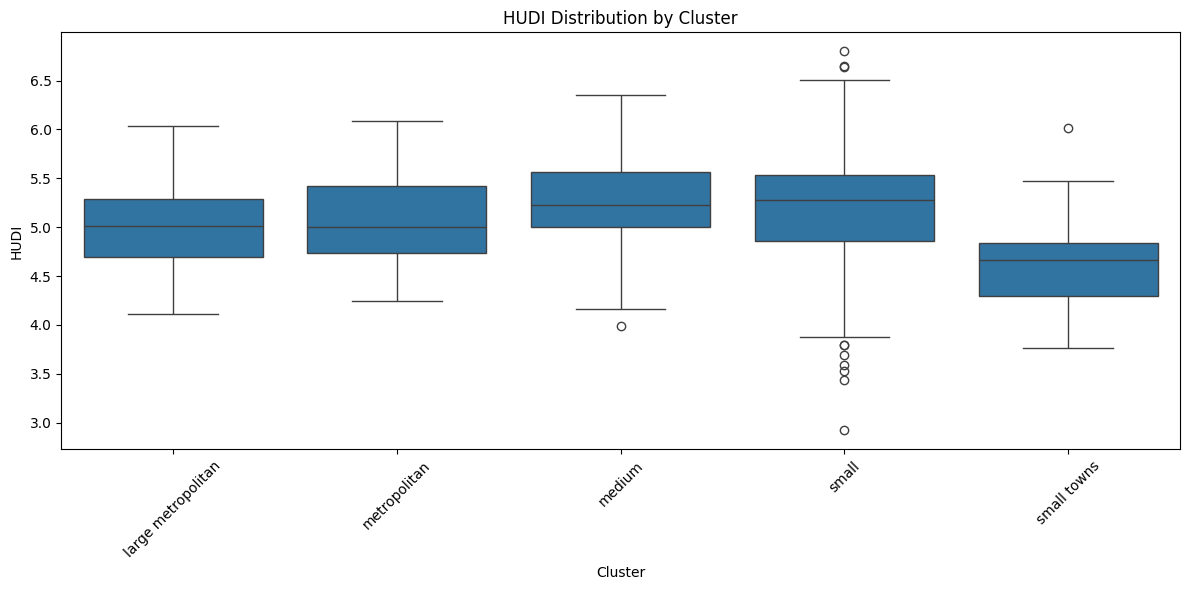

In [43]:
## Boxplot of HUDI by cluster
# Load the Excel file
df = pd.read_csv('results\\df_rank_rescaled_city.csv')
# Ensure 'rank' is numeric
df['HUDI'] = pd.to_numeric(df['HUDI'], errors='coerce')
# Order by cluster
df['cluster'] = pd.Categorical(df['cluster'], categories=clusters, ordered=True)
# Sort DataFrame by 'cluster_type'
df = df.sort_values(by='cluster')

# Plot rank distribution by cluster
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='cluster', y='HUDI', order=df['cluster'].unique())
plt.title("HUDI Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("HUDI")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('PLOTS\\boxplot_HUDI.png', dpi=300, bbox_inches='tight')
plt.show()


In [44]:
# Calculate summary statistics for rank within each cluster
rank_summary = df.groupby('cluster')['HUDI'].describe().round(2)

# Display summary statistics
rank_summary.to_excel('RESULTS\\HUDI_summary.xlsx')
rank_summary

count  mean   std   min   25%   50%   75%   max
cluster                                                            
large metropolitan   11.0  5.01  0.56  4.11  4.70  5.01  5.28  6.04
metropolitan         53.0  5.10  0.43  4.24  4.74  5.00  5.42  6.09
medium              177.0  5.25  0.45  3.99  5.00  5.23  5.56  6.35
small               638.0  5.21  0.53  2.92  4.86  5.28  5.54  6.80
small towns          38.0  4.63  0.50  3.76  4.30  4.66  4.84  6.02

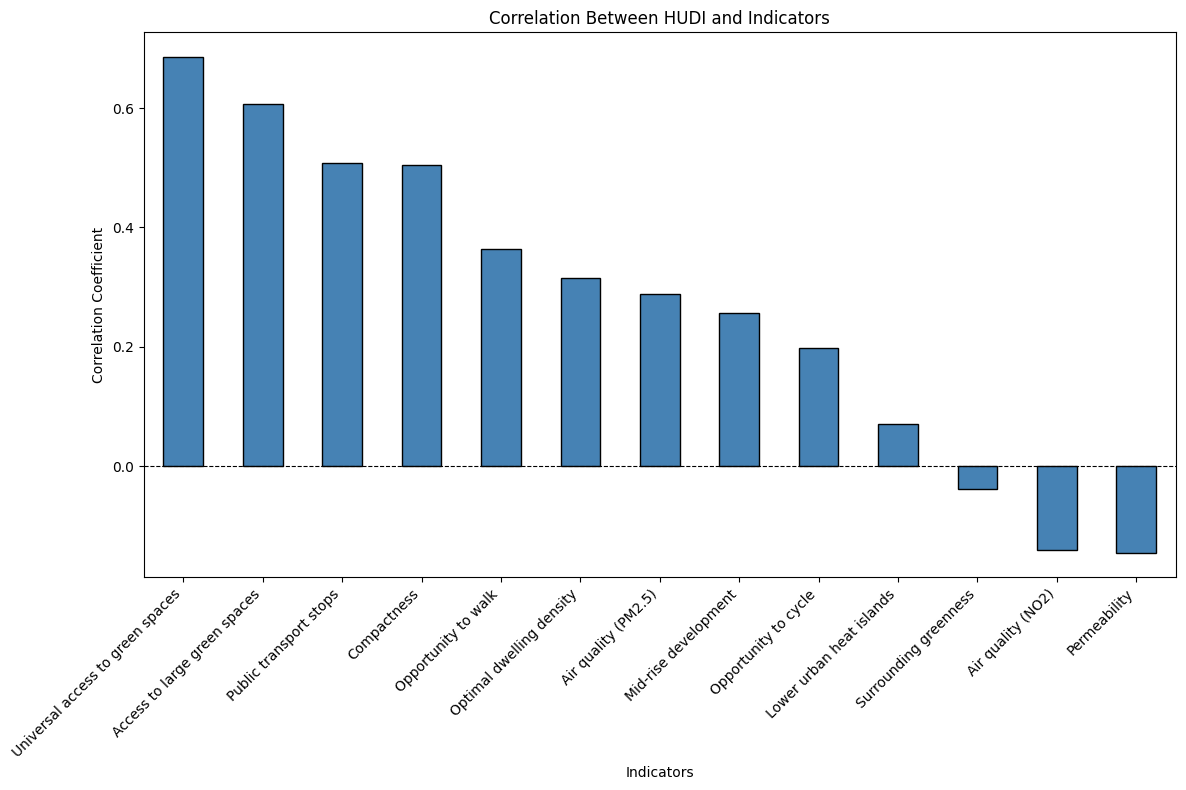

In [45]:
## Plot the correlation between HUDI and other indicators 
# Reload the dataset
df = pd.read_csv('results\\df_rank_rescaled_city.csv') 
df2 = df.drop(columns='rank_tot')
df2 = df2.drop(columns='rank')

# Ensure 'rank' is numeric
df2['HUDI'] = pd.to_numeric(df2['HUDI'], errors='coerce')
# Select numeric columns for correlation analysis
numeric_columns = df2.select_dtypes(include=[np.number]).columns

# Calculate correlation matrix between rank and other metrics
correlation_with_rank = df2[numeric_columns].corr()['HUDI'].sort_values(ascending=False)

# Exclude self-correlation
correlation_with_rank = correlation_with_rank.drop('HUDI')

# Visualize the correlation with a bar chart
plt.figure(figsize=(12, 8))
correlation_with_rank.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Correlation Between HUDI and Indicators")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Indicators")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('PLOTS\\corr_HUDI.png', dpi=300, bbox_inches='tight')

plt.show()

# Display the correlation values in a table
correlation_with_rank_df = correlation_with_rank.reset_index()
correlation_with_rank_df.columns = ['Indicators', 'Correlation with Rank']



C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\libpysal\cg\voronoi.py:173: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  region_df["geometry"] = [Polygon(vertices[region]) for region in regions]
C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\libpysal\cg\voronoi.py:176: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (Geo

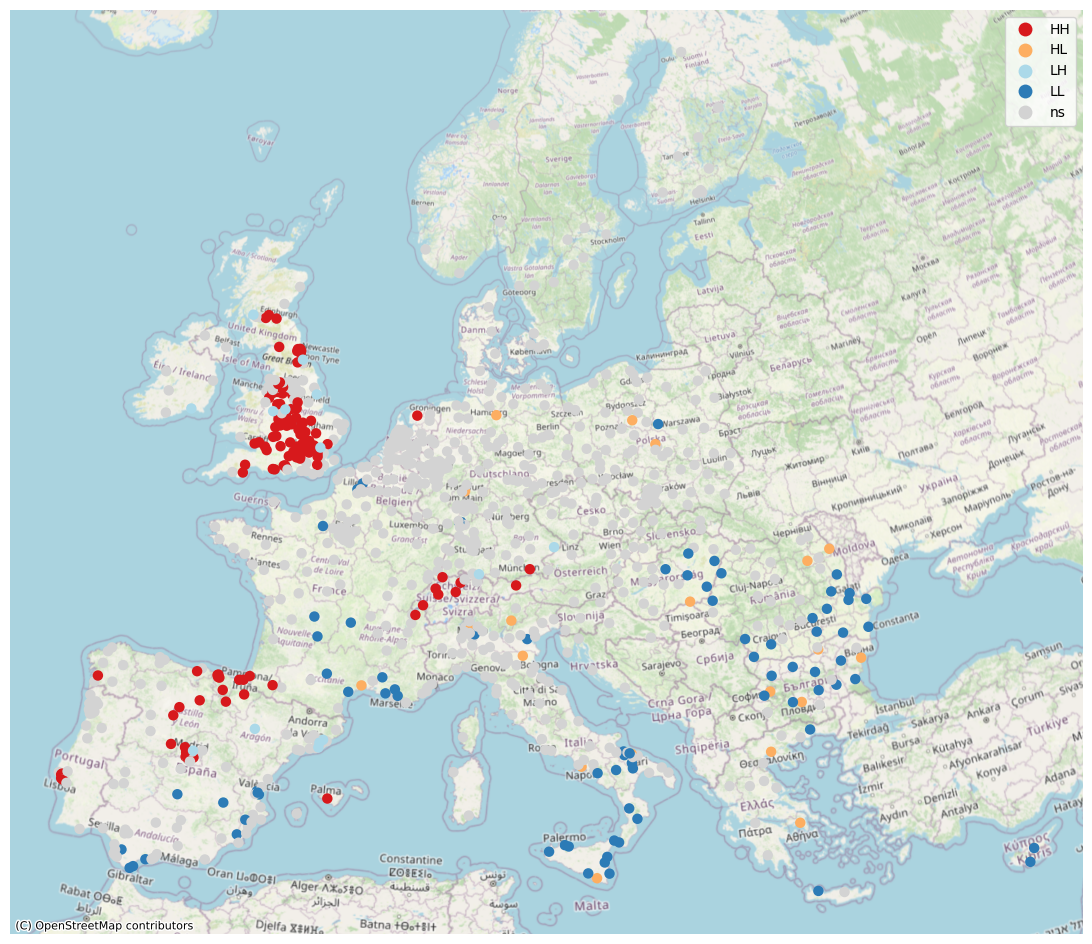

In [46]:
## Plot the LISA cluster map of HUDI
#  Load the data
gdf_centroid = gdf_plot_qgis.copy()
gdf_centroid = gdf_centroid.set_geometry('centroid')  # Ensure 'geometry' is set as the active geometry column
if gdf_centroid.crs is None:
    gdf_centroid.set_crs(epsg=3035, inplace=True)  # Assuming WGS84; adjust if necessary

# Reset the index to match the row order (required by weights.Queen)
gdf_centroid = gdf_centroid.reset_index(drop=True)

# Create spatial weights using Queen contiguity
w = Queen.from_dataframe(gdf_centroid)

# Check for islands (features without neighbors)
islands = w.islands  # List of indices for islands
if islands:
    print(f"Dropping {len(islands)} islands: {islands}")
    gdf_centroid = gdf_centroid.drop(index=islands).reset_index(drop=True)  # Drop islands and reset index
    w = Queen.from_dataframe(gdf_centroid)  # Recreate weights after dropping islands

# Transform weights to row-standardized
w.transform = 'R'

# Compute Local Moran's I
lisa = esda.Moran_Local(gdf_centroid['HUDI'], w)

# Create the LISA cluster plot
fig, ax = plt.subplots(figsize=(16, 12))  # Larger figure size for better visualization
lisa_cluster(lisa, gdf_centroid, ax=ax)

# Add a basemap for context (requires CRS in EPSG:3857)
if gdf_centroid.crs.to_string() != 'EPSG:3035':
    gdf_centroid = gdf_centroid.to_crs(epsg=3035)

ctx.add_basemap(ax=ax, crs=gdf_centroid.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize title and layout
#ax.set_title("LISA Cluster Map of HUDI", fontsize=18, pad=15)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Save the plot with high resolution
plt.savefig('PLOTS/LISA_Cluster_Map_HUDI.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [47]:
# Compute Global Moran's I for HUDI
global_moran = Moran(gdf_centroid['HUDI'], w)

# Extract key values
moran_index = global_moran.I
expected_index = global_moran.EI
p_value = global_moran.p_sim
z_score = global_moran.z_sim

# Print Results
print("Global Moran's I Results:")
print(f"Moran's I: {moran_index:.4f}")
print(f"Expected I: {expected_index:.4f}")
print(f"P-Value: {p_value:.4f}")
print(f"Z-Score: {z_score:.4f}")

Global Moran's I Results:
Moran's I: 0.3393
Expected I: -0.0011
P-Value: 0.0010
Z-Score: 17.1566


Spider Plots

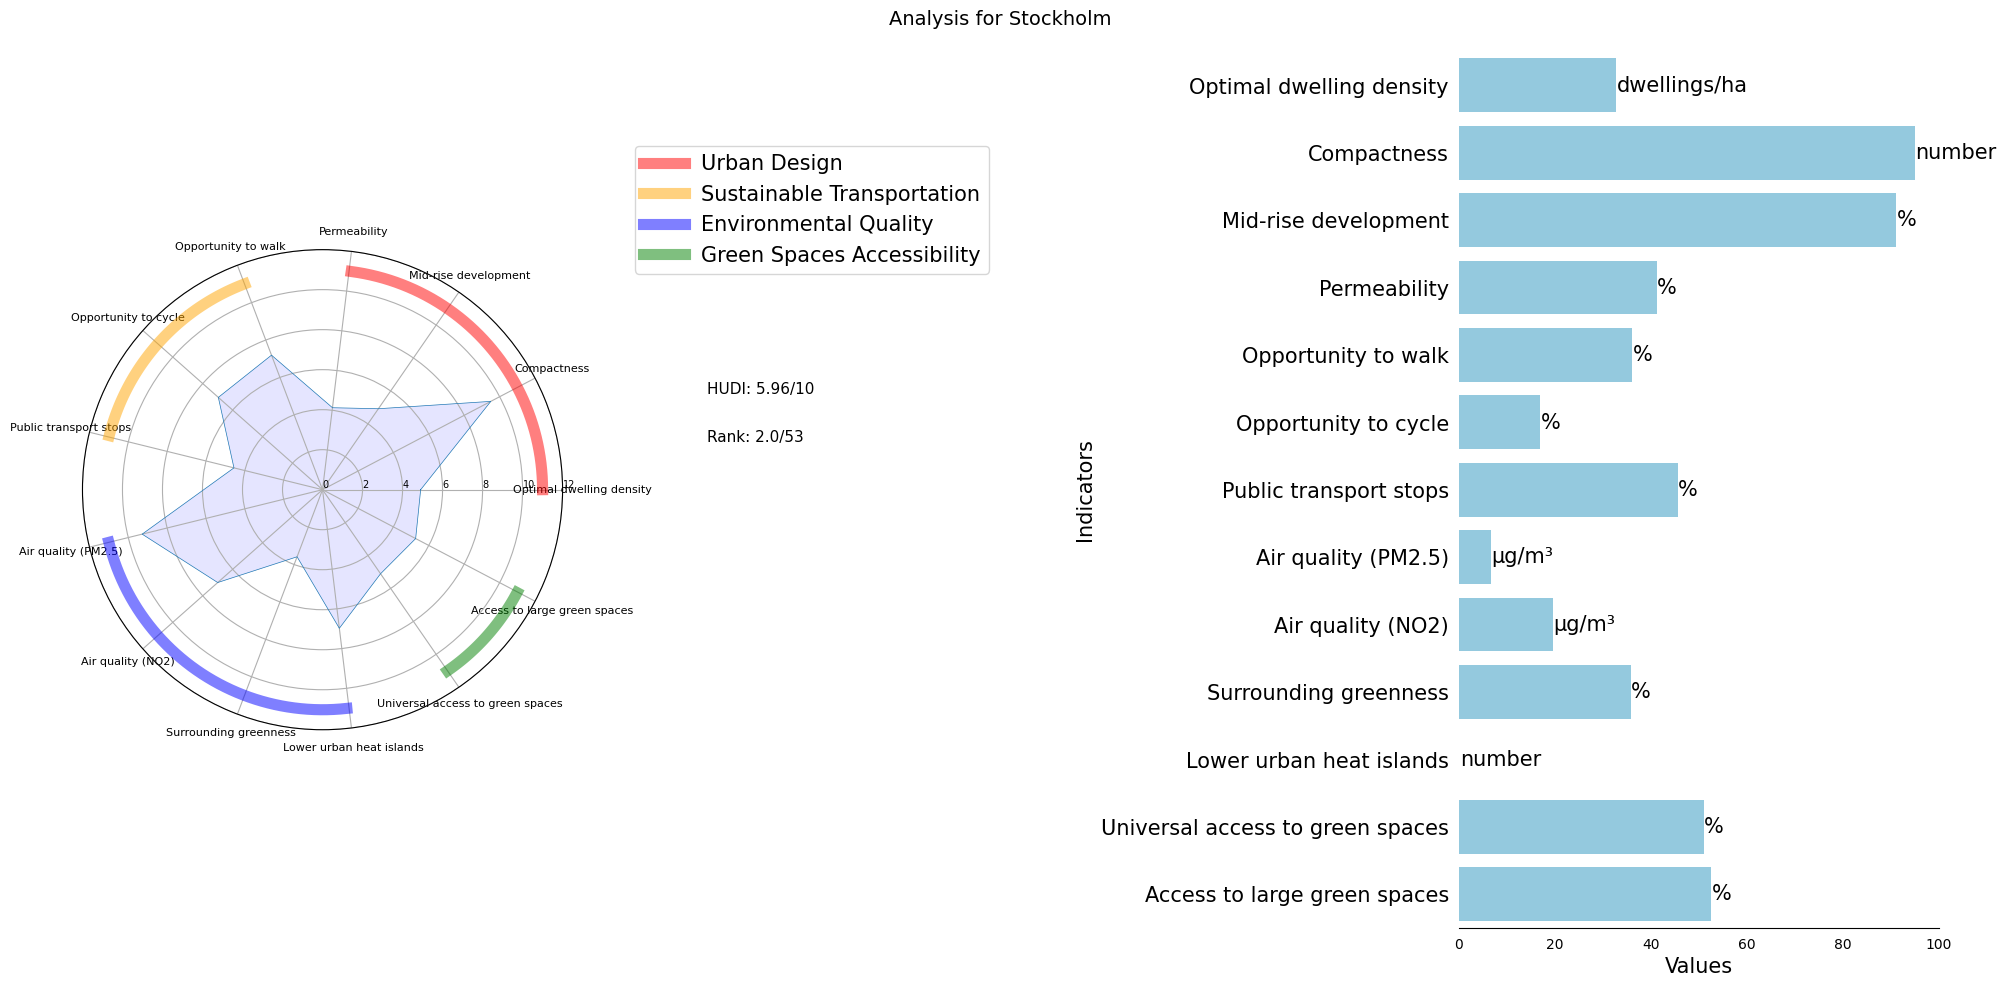

In [48]:
# Plot the Spider Plot and bar plot for each city
def plot_city_analysis(df, city_name):
    """
    Create combined spider and bar plots for two cities.
    df: DataFrame containing city data
    city_name: Name of the city to plot
    """
    # Calculate statistics and get city data
    stats = df.groupby('indicator')['val_city'].agg(['mean', 'std']).reset_index()
    city_data = df[df['urau_name'] == city_name].merge(stats, on='indicator')
    cluster = city_data['cluster'].unique()[0]
    categories = city_data['indicator'].unique()
    N = len(categories)
    urauname = city_data.urau_name.unique()[0]

    # Create figure with 2x2 grid
    fig = plt.figure(figsize=(20, 20))
    
    # First spider plot (top left)
    ax1 = fig.add_subplot(221, polar=True)
    
    # Spider plot data preparation
    values = city_data['rescaled_city'].tolist()
    values += values[:1]
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Configure spider plot
    plt.xticks(angles[:-1], categories, color='black', size=8)
    ax1.set_rlabel_position(0)
    ax1.set_rgrids([0, 2, 4, 6, 8, 10, 12])
    plt.yticks([0, 2, 4, 6, 8, 10, 12], ['0', '2', '4', '6', '8', '10', '12'], 
               color="black", size=7)
    plt.ylim(0, 12)
    
    # Plot domain arcs
    colors = ['r', 'orange', 'blue', 'g']
    for i in range(len(domains)):
        thetar = [np.arange(angles[0], angles[3], 0.01),
                 np.arange(angles[4], angles[6], 0.01),
                 np.arange(angles[7], angles[10], 0.01),
                 np.arange(angles[11], angles[12], 0.01)]
        ax1.plot(thetar[i], np.full_like(thetar[i], 11), 
                color=colors[i], linewidth=8, alpha=0.5)
    
    # Add spider plot elements
    ax1.plot(angles, values, linewidth=0.5, linestyle='solid')
    ax1.fill(angles, values, 'b', alpha=0.1)
    
    # Add text annotations
    plt.text(1.3, 0.7, f'HUDI: {city_data["HUDI"].iloc[0].round(2)}/10', 
             transform=ax1.transAxes, fontsize=11)
    plt.text(1.3, 0.6, 
             f'Rank: {city_data["rank"].iloc[0]}/{df[df.cluster==cluster].urau_code.nunique()}',
             transform=ax1.transAxes, fontsize=11)
    
    # Add legend
    legend = ax1.legend(domains, loc=(1.15, .95), labelspacing=0.5, fontsize=15)
    
    # First bar plot (top right)
    ax2 = fig.add_subplot(222)
    sns.barplot(data=city_data, y='indicator', x='val_city', 
                color='skyblue', ax=ax2)
    
    # Add measure annotations
    for index, row in city_data.iterrows():
        ax2.text(row['val_city'] + 0.1, index, row['measure'],
                va='center', fontsize=15)
    
    # Clean up bar plot
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.yaxis.set_ticks_position('none')
    ax2.tick_params(axis='y', labelsize=15)  # Adjust labelsize to desired value
    ax2.tick_params(left=False, bottom=False)
    ax2.set_xlabel('Values',fontsize=15)
    ax2.set_ylabel('Indicators', fontsize = 15)
    ax2.set_xlim(0,100)

    # Add title
    plt.suptitle(f'Analysis for {urauname}', fontsize=14, y=0.95)
    
    # Adjust layout
    plt.tight_layout(w_pad=4, h_pad=3)  # Increase spacing between plots
    
    # Save figure
    plt.savefig(f'PLOTS\\spider\\{urauname}_combined.png', 
                bbox_inches='tight', dpi=300)
    

# Call the function
# Load the data
df0 = pd.read_csv('results\\df_rank0.csv')
# Merge the df_city containing the rescaled values with the df0 containing the rank
df = pd.merge(df_city, df0[['urau_code','rank','HUDI']], on='urau_code', how = 'left')

# Select a city to plot
urauname = 'Stockholm'
plot_city_analysis(df, urauname)

GRIDS PLOT

In [ ]:
# Include geometry
# Load geometry data
b = gpd.read_file('DATA\\data\\gdf_pop.geojson') 
b = b.to_crs('EPSG:3035')
# Load boundary data
boundaries = gpd.read_file('DATA\\data\\all_cities.shp')
# Load london boundary data
gdf_london = gpd.read_file('DATA\data\london_cities.gpkg')
gdf_london = gdf_london.to_crs('EPSG:3035')

In [ ]:
# Load df_grid containing indicators data at grid level
df = df_grid.copy()
# Merge with geometry
gdf = pd.merge(df, b[['urau_code' ,'gid', 'geometry']], on=['urau_code','gid'], how='left')
gdf = gpd.GeoDataFrame(gdf, geometry = gdf['geometry'])
rows_with_none_geometry = gdf[gdf['geometry'].isnull()]
# Remove rows where geometry is null
gdf2 = gdf[gdf['geometry'].notnull()]

# Remove rows with no geometry
rows_with_none_geometry = rows_with_none_geometry.drop(columns=['geometry'])
gdf3 = rows_with_none_geometry.merge(gdf_london[['gid', 'geometry']], on='gid', how='left')
gdf3 = rows_with_none_geometry.merge(gdf_london[['gid', 'geometry']], on='gid', how='left')

# Concatenate gdf2 and gdf3
gdftot = gpd.GeoDataFrame(pd.concat([gdf2, gdf3], ignore_index=True), crs=gdf2.crs)

In [ ]:
## Compute HUDI at grid cell level 
df = df_grid.copy()
# Merge with the geometry
gdf = pd.merge(df, b[['urau_code' ,'gid', 'geometry']], on=['urau_code','gid'], how='left')
gdf = gpd.GeoDataFrame(gdf, geometry = gdf['geometry'])

# Compute the mean of the indicators inside the same domain
df = gdftot.copy()
df['mean_domain'] = df.groupby(['urau_code', 'domain', 'gid'])['rescaled_grid'].transform('mean')
df = df.drop_duplicates(subset=['urau_code', 'domain', 'gid'])

# Compute weights
df['weight'] = 1
df.loc[df['domain'] == 'Sustainable Transportation', 'weight'] = 0.5

# Compute weighted values
df['weighted_value'] = df['mean_domain'] * df['weight']

# Group by 'gid' and compute the HUDI
grid_hudi = df.groupby('gid', as_index=False).agg(
    weighted_sum=('weighted_value', 'sum'),
    total_weight=('weight', 'sum')
)
grid_hudi['HUDI'] = grid_hudi['weighted_sum'] / grid_hudi['total_weight']

# Display the result
final_df = pd.merge(df, grid_hudi, on='gid', how='left')
#final_df.to_csv('results\\HUDI_grids.csv', index=False)

In [ ]:
# Plot the domains, HUDI and LISA plot at grid cell level 
# plot_city is a function that plots the 2x3 grid of domain maps + HUDI + Local Spatial Analysis for a given (urau_code, cluster)
# Call the function in a loop for the cities in the cluster

# Define the domains and color palettes
color_palettes = ['Reds', 'Oranges', 'Blues', 'Greens']  # Color palettes for each plot

def plot_city(urau_code, cluster, final_df, boundaries):
    """
    Plots the 2x3 grid of domain maps + HUDI + Local Spatial Analysis
    for a given (urau_code, cluster).
    Saves the figure to PLOTS/website/<cluster>/<urau_code>.png
    """

    # Filter data for this city
    gdf2 = final_df[final_df.urau_code == urau_code].copy()
    if gdf2.empty:
        print(f"No data for {urau_code}. Skipping.")
        return

    # Convert to GeoDataFrame if not already
    gdf2 = gpd.GeoDataFrame(gdf2).set_geometry('geometry')

    # Create a 2x3 figure
    fig, axs = plt.subplots(2, 3, figsize=(80, 70))

    # ----------------------------------------------------------
    # 1. Plot the 4 "domains" in the top-left, top-middle, bottom-left, etc.
    # ----------------------------------------------------------
    for i, (core, cmap) in enumerate(zip(domains, color_palettes)):
        gdff = gdf2[gdf2['domain'] == core].copy()

        row = i // 3
        col = i % 3
        ax = axs[row, col]

        gdff.plot(
            column='mean_domain',
            scheme="quantiles",
            k=4,
            cmap=cmap,
            alpha=1,
            ax=ax,
            edgecolor='grey',
            legend=True,
            legend_kwds={
                'loc': 'upper right',
                'bbox_to_anchor': (1.23, 1.01),
                'fmt': '{:.2f}',
                'markerscale': 5,
                'title_fontsize': 50,
                'fontsize': 50
            }
        )
        # Overplot city boundary
        boundaries[boundaries.urau_code == urau_code].plot(
            ax=ax, color='none', edgecolor='black'
        )
        ax.set_title(core, fontsize=60)
        ax.set_axis_off()

    # ----------------------------------------------------------
    # 2. Plot HUDI in bottom-middle (ax[1,1])
    # ----------------------------------------------------------
    ax_hudi = axs[1, 1]
    gdf2.plot(
        column='HUDI',
        scheme="quantiles",
        k=4,
        cmap="RdYlGn",
        alpha=0.6,
        ax=ax_hudi,
        edgecolor='grey',
        legend=True,
        legend_kwds={
            'loc': 'upper right',
            'bbox_to_anchor': (1.23, 1.01),
            'fmt': '{:.2f}',
            'markerscale': 5,
            'title_fontsize': 50,
            'fontsize': 50
        }
    )
    boundaries[boundaries.urau_code == urau_code].plot(
        ax=ax_hudi, color='none', edgecolor='black'
    )
    ax_hudi.set_title('HUDI', fontsize=60)
    ax_hudi.set_axis_off()

    # ----------------------------------------------------------
    # 3. Local Spatial Analysis (LISA)
    # ----------------------------------------------------------
    ax_lisa = axs[1, 2]

    # Ensure we have a valid CRS
    if gdf2.crs is None:
        # Example: If data is actually in EPSG:3035
        gdf2.set_crs(epsg=3035, inplace=True)

    # Reset index for weight creation
    gdf2 = gdf2.reset_index(drop=True)

    w = Queen.from_dataframe(gdf2)
    islands = w.islands
    if islands:
        gdf2 = gdf2.drop(index=islands).reset_index(drop=True)
        w = Queen.from_dataframe(gdf2)

    w.transform = 'R'

    lisa = esda.Moran_Local(gdf2['HUDI'], w)
    lisa_cluster(
        lisa, 
        gdf2, 
        ax=ax_lisa,
        p=0.05,
        legend=True,
        legend_kwds={
            'loc': 'upper left',
            'bbox_to_anchor': (1, 1),
            'prop': {'size': 50},  
            'markerscale': 5,
            'labelspacing': 1.2,
        }
    )
    boundaries[boundaries.urau_code == urau_code].plot(
        ax=ax_lisa, color='none', edgecolor='black'
    )
    ax_lisa.set_title("Local Spatial Clusters (HUDI)", fontsize=60)
    ax_lisa.set_axis_off()

    # Optionally tweak the legend from the LISA plot
    legend = ax_lisa.get_legend()
    if legend:
        # Update legend labels
        new_labels = {
            "HH": "High-High",
            "LL": "Low-Low",
            "LH": "Low-High",
            "HL": "High-Low",
            "NS": "Not Significant"
        }
        for text in legend.get_texts():
            label = text.get_text()
            if label in new_labels:
                text.set_text(new_labels[label])


    # ----------------------------------------------------------
    # Finalize and save
    # ----------------------------------------------------------
    plt.tight_layout()

    # Ensure directory for this cluster exists
    output_dir = f"PLOTS/website/{cluster}/jpg/"
    os.makedirs(output_dir, exist_ok=True)

    # Save the figure
    plt.savefig(
        f"{output_dir}/{urau_code}.jpg", 
        bbox_inches='tight', 
        pad_inches=0
    )
    plt.close(fig)  # Close the figure to free memory

C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)
C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 38 disconnected components.
  warnings.warn(message)
C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 59 disconnected components.
  warnings.warn(message)
C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique val

In [ ]:
# -------------------------------------------------------------------
# LOOP OVER ALL CITIES
# -------------------------------------------------------------------
# Extract unique (urau_code, cluster) pairs
final_df2 = final_df[final_df.cluster=='large metropolitan'] # Select the cluster!!
unique_cities = final_df2[['urau_code', 'cluster']].drop_duplicates()
unique_cities = unique_cities.iloc[92:]

from utility import domains
core_list = domains

for idx, row in unique_cities.iterrows():
    urau = row['urau_code']
    cluster = row['cluster']
    plot_city(urau, cluster, final_df, boundaries)

C:\Users\fmontana\AppData\Roaming\Python\Python39\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  warnings.warn(message)


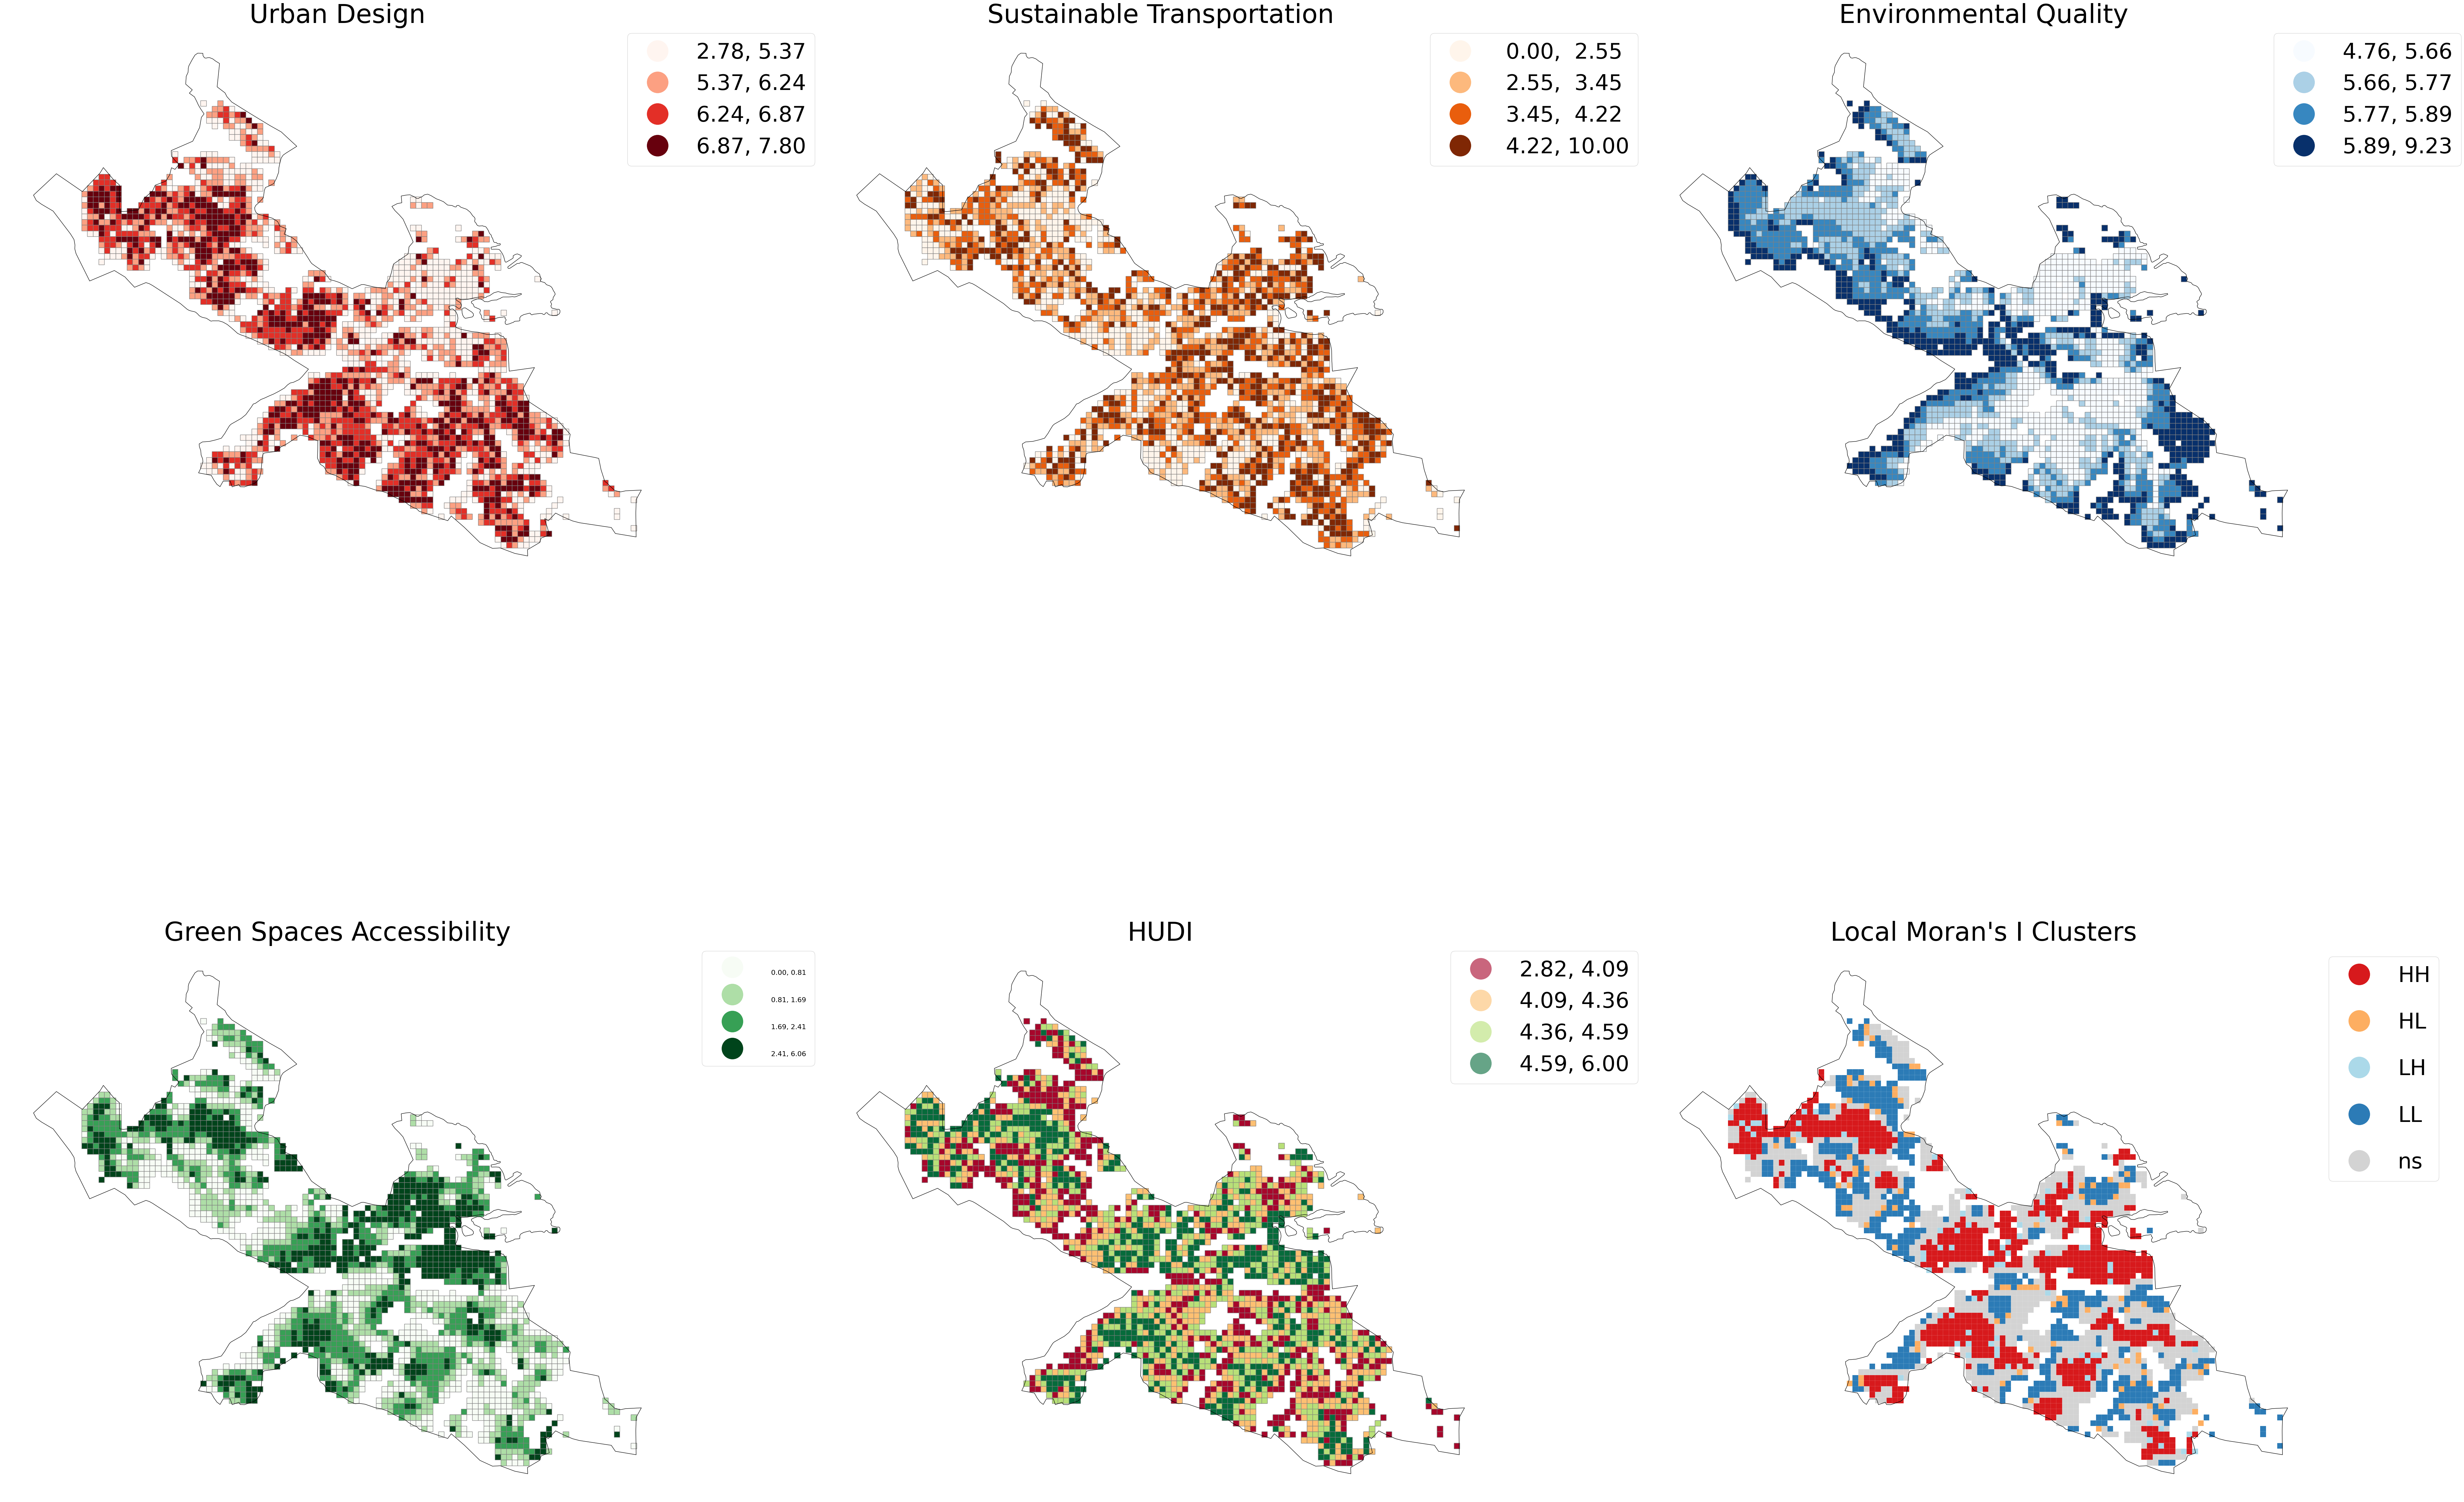

In [ ]:
# PLOT just one city at grid-cell level

from utility import domains
core_list = domains
color_palettes = ['Reds', 'Oranges', 'Blues', 'Greens']  # Color palettes for each plot

uraucode='SE001C1'
cluster = 'large metropolitan'

gdf2 = final_df[final_df.urau_code == uraucode]
gdf2 = gpd.GeoDataFrame(gdf2)
# Create a 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(80, 70))

# Iterate through each core category
for i, (core, cmap) in enumerate(zip(domains, color_palettes)):
    gdff = gdf2[gdf2['domain'] == core]
    #gdff = gdff.copy()
    #gdff['mean_rescaled_col'] = gdff.groupby('gid')['rescaled_grid'].transform('mean')

    # Determine the position in the subplot grid
    row = i // 3
    col = i % 3

    # Plot the data on the corresponding subplot
    ax = axs[row, col]
    gdf_plot = gdff.plot(
        column='mean_domain',
        scheme="quantiles",
        k=4,
        cmap=cmap,
        alpha=1,
        ax=ax,
        edgecolor='grey',
        legend=True,  # Include legend for HUDI plot,
        legend_kwds={
        'loc':'upper right',
        'bbox_to_anchor':(1.23, 1.01), 
        'fmt':'{:.2f}',
        'markerscale':5, 
        'title_fontsize': 50, 
        'fontsize': 50
        }
        ) 
    plt.tight_layout()
    #ctx.add_basemap(ax=ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

    
    boundaries[boundaries.urau_code == uraucode].geometry.plot(ax=ax, color='none', edgecolor='black')
    ax.set_title(core, fontsize=60)  # Set subplot title
    ax.set_axis_off()  # Hide the axis

# Plot the HUDI figure
ax_hudi = axs[1, 1]  # Position in the grid
gdf2.plot(
    column='HUDI',
    scheme="quantiles",
    k=4,
    cmap="RdYlGn",
    alpha=0.6,
    ax=ax_hudi,
    edgecolor='grey',
    legend=True,
    legend_kwds={
        'loc': 'upper right',
        'bbox_to_anchor': (1.23, 1.01),
        'fmt': '{:.2f}',
        'markerscale': 5,
        'title_fontsize': 50,
        'fontsize': 50
    }
)
#ctx.add_basemap(ax=ax, crs=gdf2.crs, source=ctx.providers.OpenStreetMap.Mapnik)
boundaries[boundaries.urau_code == uraucode].geometry.plot(ax=ax_hudi, color='none', edgecolor='black')
ax_hudi.set_title('HUDI', fontsize=60)
ax_hudi.set_axis_off()  # Hide the axis for HUDI subplot

# LOCAL SPATIAL ANALYSIS
ax_hudi = axs[1, 2]
gdf2 = gdf2.set_geometry('geometry')  # Ensure 'geometry' is set as the active geometry column
if gdf2.crs is None:
    gdf2.set_crs(epsg=3035, inplace=True)  # Assuming WGS84; adjust if necessary

# Reset the index to match the row order (required by weights.Queen)
gdf2 = gdf2.reset_index(drop=True)

# Create spatial weights using Queen contiguity
w = Queen.from_dataframe(gdf2)

# Check for islands (features without neighbors)
islands = w.islands  # List of indices for islands
if islands:
    gdf2 = gdf2.drop(index=islands).reset_index(drop=True)  # Drop islands and reset index
    w = Queen.from_dataframe(gdf2)  # Recreate weights after dropping islands

# Transform weights to row-standardized
w.transform = 'R'

# Compute Local Moran's I
lisa = esda.Moran_Local(gdf2['HUDI'], w)

# Create the LISA cluster plot
lisa_cluster(
    lisa, 
    gdf2, 
    ax=ax_hudi,
    p=0.05,             # significance threshold
    legend=True,        # enable legend creation
    legend_kwds={
        'loc': 'upper left',
        'bbox_to_anchor': (1, 1),
        'prop': {'size': 50},  
        'markerscale': 5,       # scales up the marker size in the legend
        'labelspacing': 1.2,    # spacing between legend entries
    }
)
# Customize the legend manually

# Add a basemap for context (requires CRS in EPSG:3857)
if gdf2.crs.to_string() != 'EPSG:3035':
    gdf2 = gdf2.to_crs(epsg=3035)
boundaries[boundaries.urau_code == uraucode].geometry.plot(ax=ax_hudi, color='none', edgecolor='black')
ax_hudi.set_title("Local Moran's I Clusters", fontsize=60)
legend = ax.get_legend()
if legend:
    # Change the legend title font    
    # Increase font size for all labels
    for text in legend.get_texts():
        text.set_fontsize(16)

# Adjust layout and save the figure
#plt.tight_layout()
#plt.savefig(f"PLOTS\\website\\{cluster}\\{uraucode}.png", bbox_inches='tight', pad_inches=0)

plt.show()